<a href="https://colab.research.google.com/github/Subhoshri/DedSec_Brain_Dead_2k25/blob/main/DedSec_Brain_Dead_2k25_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 1
Let's first import all the necessary libraries to explore the data and predict the outcome of IPL matches 2025.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

Now loading the matches.csv and the deliveries.csv file to work on it.

In [4]:
matches_path = "/content/matches.csv"
deliveries_path = "/content/deliveries.csv"

matches_df = pd.read_csv(matches_path)
deliveries_df = pd.read_csv(deliveries_path)

Before starting with data preprocessing, it's necessary to understand the data we are working with. So we are checking the dimensionality and if any missing values are present or not.

In [5]:
print("Dimensionality of Matches Dataset:")
print(matches_df.shape)
print("Missing Values in Matches Dataset:")
print(matches_df.isnull().sum())

print("\nDimensionality of Deliveries Dataset:")
print(deliveries_df.shape)
print("Missing Values in Deliveries Dataset:")
print(deliveries_df.isnull().sum())

Dimensionality of Matches Dataset:
(1095, 20)
Missing Values in Matches Dataset:
id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64

Dimensionality of Deliveries Dataset:
(260920, 17)
Missing Values in Deliveries Dataset:
match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batter                   0
bowler                   0
non_striker              0
batsman_runs             0
extra_runs               0
total_runs               0
extras_type 

A lot of missing values are due to no data for that scenario. So it's best to assume some value instead of dropping them. Here, we are taking 0 for numerical data and 'Unknown' for categorical data.

In [6]:
# For simplicity, let's fill missing values with a placeholder (e.g., 'Unknown' for categorical data, 0 for numerical data)
matches_df['city'].fillna('Unknown', inplace=True)
matches_df['winner'].fillna('No Result', inplace=True)
matches_df['method'].fillna('None', inplace=True)
matches_df['umpire1'].fillna('Unknown', inplace=True)
matches_df['umpire2'].fillna('Unknown', inplace=True)
matches_df['result_margin'].fillna(0, inplace=True)
matches_df['player_of_match'].fillna('None', inplace=True)
matches_df['target_runs'].fillna(0, inplace=True)
matches_df['target_overs'].fillna(0, inplace=True)

deliveries_df['player_dismissed'].fillna('None', inplace=True)
deliveries_df['dismissal_kind'].fillna('None', inplace=True)
deliveries_df['fielder'].fillna('None', inplace=True)
deliveries_df['extras_type'].fillna('None', inplace=True)

Now that there are no missing values, we can move forward.

In [7]:
print("Missing Values in Matches Dataset after handling:")
print(matches_df.isnull().sum())

print("\nMissing Values in Deliveries Dataset after handling:")
print(deliveries_df.isnull().sum())

Missing Values in Matches Dataset after handling:
id                 0
season             0
city               0
date               0
match_type         0
player_of_match    0
venue              0
team1              0
team2              0
toss_winner        0
toss_decision      0
winner             0
result             0
result_margin      0
target_runs        0
target_overs       0
super_over         0
method             0
umpire1            0
umpire2            0
dtype: int64

Missing Values in Deliveries Dataset after handling:
match_id            0
inning              0
batting_team        0
bowling_team        0
over                0
ball                0
batter              0
bowler              0
non_striker         0
batsman_runs        0
extra_runs          0
total_runs          0
extras_type         0
is_wicket           0
player_dismissed    0
dismissal_kind      0
fielder             0
dtype: int64


Let us look at the unique teams so that we can work with those and avoid repetition.

In [8]:
print("Unique team names in matches dataset (team1):")
print(matches_df['team1'].unique())
print("\nUnique team names in matches dataset (team2):")
print(matches_df['team2'].unique())
print("\nUnique team names in matches dataset (winner):")
print(matches_df['winner'].unique())
print("\nUnique team names in matches dataset (toss_winner):")
print(matches_df['toss_winner'].unique())

print("\nUnique team names in deliveries dataset (batting_team):")
print(deliveries_df['batting_team'].unique())
print("\nUnique team names in deliveries dataset (bowling_team):")
print(deliveries_df['bowling_team'].unique())

Unique team names in matches dataset (team1):
['Royal Challengers Bangalore' 'Kings XI Punjab' 'Delhi Daredevils'
 'Mumbai Indians' 'Kolkata Knight Riders' 'Rajasthan Royals'
 'Deccan Chargers' 'Chennai Super Kings' 'Kochi Tuskers Kerala'
 'Pune Warriors' 'Sunrisers Hyderabad' 'Gujarat Lions'
 'Rising Pune Supergiants' 'Rising Pune Supergiant' 'Delhi Capitals'
 'Punjab Kings' 'Lucknow Super Giants' 'Gujarat Titans'
 'Royal Challengers Bengaluru']

Unique team names in matches dataset (team2):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Rajasthan Royals'
 'Royal Challengers Bangalore' 'Deccan Chargers' 'Kings XI Punjab'
 'Delhi Daredevils' 'Mumbai Indians' 'Kochi Tuskers Kerala'
 'Pune Warriors' 'Sunrisers Hyderabad' 'Rising Pune Supergiants'
 'Gujarat Lions' 'Rising Pune Supergiant' 'Delhi Capitals' 'Punjab Kings'
 'Gujarat Titans' 'Lucknow Super Giants' 'Royal Challengers Bengaluru']

Unique team names in matches dataset (winner):
['Kolkata Knight Riders' 'Chennai Super Kings' 'De

Some of the same teams have different names, depending upon the year. Since this  is a vast dataset from 2008 to 2024, there are bound to be changes. Let us keep one unique team name for each of the repetitions.

In [9]:
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Rising Pune Supergiant': 'Rising Pune Supergiants',
    'Kings XI Punjab': 'Punjab Kings',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Gujarat Lions': 'Gujarat Titans',
}

# Apply the mapping to the matches dataset
matches_df['team1'] = matches_df['team1'].replace(team_name_mapping)
matches_df['team2'] = matches_df['team2'].replace(team_name_mapping)
matches_df['winner'] = matches_df['winner'].replace(team_name_mapping)
matches_df['toss_winner'] = matches_df['toss_winner'].replace(team_name_mapping)

# Apply the mapping to the deliveries dataset
deliveries_df['batting_team'] = deliveries_df['batting_team'].replace(team_name_mapping)
deliveries_df['bowling_team'] = deliveries_df['bowling_team'].replace(team_name_mapping)

# Verify the standardization
print("Unique team names in matches dataset (team1):")
print(matches_df['team1'].unique())
print("\nUnique team names in matches dataset (team2):")
print(matches_df['team2'].unique())
print("\nUnique team names in matches dataset (winner):")
print(matches_df['winner'].unique())
print("\nUnique team names in matches dataset (toss_winner):")
print(matches_df['toss_winner'].unique())

print("\nUnique team names in deliveries dataset (batting_team):")
print(deliveries_df['batting_team'].unique())
print("\nUnique team names in deliveries dataset (bowling_team):")
print(deliveries_df['bowling_team'].unique())

Unique team names in matches dataset (team1):
['Royal Challengers Bengaluru' 'Punjab Kings' 'Delhi Capitals'
 'Mumbai Indians' 'Kolkata Knight Riders' 'Rajasthan Royals'
 'Sunrisers Hyderabad' 'Chennai Super Kings' 'Kochi Tuskers Kerala'
 'Pune Warriors' 'Gujarat Titans' 'Rising Pune Supergiants'
 'Lucknow Super Giants']

Unique team names in matches dataset (team2):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Rajasthan Royals'
 'Royal Challengers Bengaluru' 'Sunrisers Hyderabad' 'Punjab Kings'
 'Delhi Capitals' 'Mumbai Indians' 'Kochi Tuskers Kerala' 'Pune Warriors'
 'Rising Pune Supergiants' 'Gujarat Titans' 'Lucknow Super Giants']

Unique team names in matches dataset (winner):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Delhi Capitals'
 'Royal Challengers Bengaluru' 'Rajasthan Royals' 'Punjab Kings'
 'Sunrisers Hyderabad' 'Mumbai Indians' 'Pune Warriors'
 'Kochi Tuskers Kerala' 'No Result' 'Rising Pune Supergiants'
 'Gujarat Titans' 'Lucknow Super Giants']

Unique team name

Now some of the teams are not playing in IPL 2025, so it's essential to remove them.

In [10]:
active_teams = [
    'Chennai Super Kings', 'Delhi Capitals', 'Gujarat Titans', 'Kolkata Knight Riders',
    'Lucknow Super Giants', 'Mumbai Indians', 'Punjab Kings', 'Rajasthan Royals',
    'Royal Challengers Bengaluru', 'Sunrisers Hyderabad'
]

# Filter the matches dataset
matches_df = matches_df[
    matches_df['team1'].isin(active_teams) &
    matches_df['team2'].isin(active_teams) &
    matches_df['winner'].isin(active_teams) &
    matches_df['toss_winner'].isin(active_teams)
]

# Filter the deliveries dataset
deliveries_df = deliveries_df[
    deliveries_df['batting_team'].isin(active_teams) &
    deliveries_df['bowling_team'].isin(active_teams)
]

# Verify the filtering
print("Unique team names in matches dataset (team1):")
print(matches_df['team1'].unique())
print("\nUnique team names in matches dataset (team2):")
print(matches_df['team2'].unique())
print("\nUnique team names in matches dataset (winner):")
print(matches_df['winner'].unique())
print("\nUnique team names in matches dataset (toss_winner):")
print(matches_df['toss_winner'].unique())

print("\nUnique team names in deliveries dataset (batting_team):")
print(deliveries_df['batting_team'].unique())
print("\nUnique team names in deliveries dataset (bowling_team):")
print(deliveries_df['bowling_team'].unique())

Unique team names in matches dataset (team1):
['Royal Challengers Bengaluru' 'Punjab Kings' 'Delhi Capitals'
 'Mumbai Indians' 'Kolkata Knight Riders' 'Rajasthan Royals'
 'Sunrisers Hyderabad' 'Chennai Super Kings' 'Gujarat Titans'
 'Lucknow Super Giants']

Unique team names in matches dataset (team2):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Rajasthan Royals'
 'Royal Challengers Bengaluru' 'Sunrisers Hyderabad' 'Punjab Kings'
 'Delhi Capitals' 'Mumbai Indians' 'Gujarat Titans' 'Lucknow Super Giants']

Unique team names in matches dataset (winner):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Delhi Capitals'
 'Royal Challengers Bengaluru' 'Rajasthan Royals' 'Punjab Kings'
 'Sunrisers Hyderabad' 'Mumbai Indians' 'Gujarat Titans'
 'Lucknow Super Giants']

Unique team names in matches dataset (toss_winner):
['Royal Challengers Bengaluru' 'Chennai Super Kings' 'Rajasthan Royals'
 'Mumbai Indians' 'Sunrisers Hyderabad' 'Punjab Kings'
 'Kolkata Knight Riders' 'Delhi Capitals' 'Guja

Now we have a clean dataset, let's start with the Exploratory Data Analysis.

# Exploratory Data Analysis

## Team Performance
### 1. Plotting Matches Played and Winning Percentages for each team

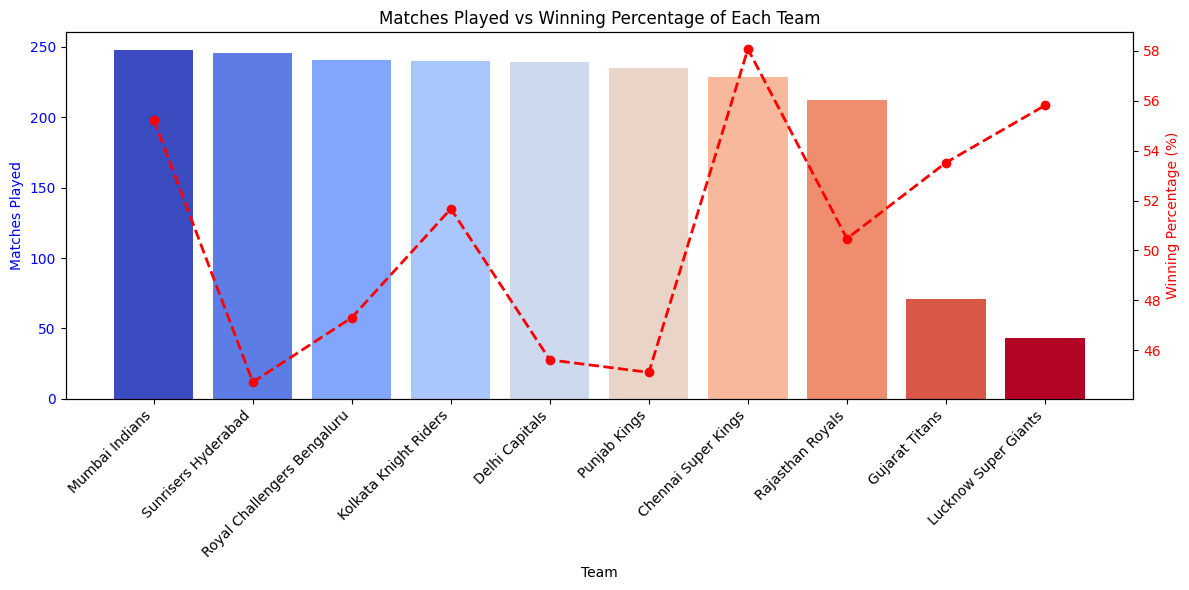

In [11]:
# Calculate team performance
matches_played = matches_df['team1'].value_counts() + matches_df['team2'].value_counts()
matches_won = matches_df['winner'].value_counts()
winning_percentage = (matches_won / matches_played) * 100

# Create DataFrame
team_performance_df = pd.DataFrame({
    'Matches Played': matches_played,
    'Matches Won': matches_won,
    'Winning Percentage': winning_percentage
}).reset_index().rename(columns={'index': 'Team'})

# Fix NaN values (for teams with no wins)
team_performance_df.fillna(0, inplace=True)

team_performance_df.sort_values(by="Matches Played", ascending=False, inplace=True)

colors = plt.cm.coolwarm(np.linspace(0, 1, len(team_performance_df)))
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Matches Played
ax1.bar(team_performance_df['Team'], team_performance_df['Matches Played'], color=colors, label="Matches Played")
ax1.set_xlabel("Team")
ax1.set_ylabel("Matches Played", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(team_performance_df['Team'], rotation=45, ha='right')

# Secondary y-axis for Winning Percentage
ax2 = ax1.twinx()
ax2.plot(team_performance_df['Team'], team_performance_df['Winning Percentage'], marker='o', linestyle='dashed',
         color='red', linewidth=2, label="Winning Percentage")
ax2.set_ylabel("Winning Percentage (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Matches Played vs Winning Percentage of Each Team")
fig.tight_layout()
plt.show()


## Key Takeaways
Mumbai Indians, Sunrisers Hyderabad, and Royal Challengers Bengaluru have played the most matches, with Mumbai Indians leading slightly.

Winning Percentage varies significantly across teams - while some teams with high matches played (e.g., Mumbai Indians) maintain a strong win rate, others (e.g., Punjab Kings) struggle.

Chennai Super Kings (CSK) stands out with a high winning percentage despite not having the absolute highest matches played.

Newer teams like Gujarat Titans and Lucknow Super Giants have played fewer matches but still maintain a competitive winning percentage.

Sunrisers Hyderabad shows an interesting trend - high matches played but the lowest winning percentage compared to other teams.

Teams with high matches played but lower winning percentages might need strategic improvements, while those with lower matches played but strong win rates show promising potential.

### 2. Plotting Run Rate and Economy Rate for each team

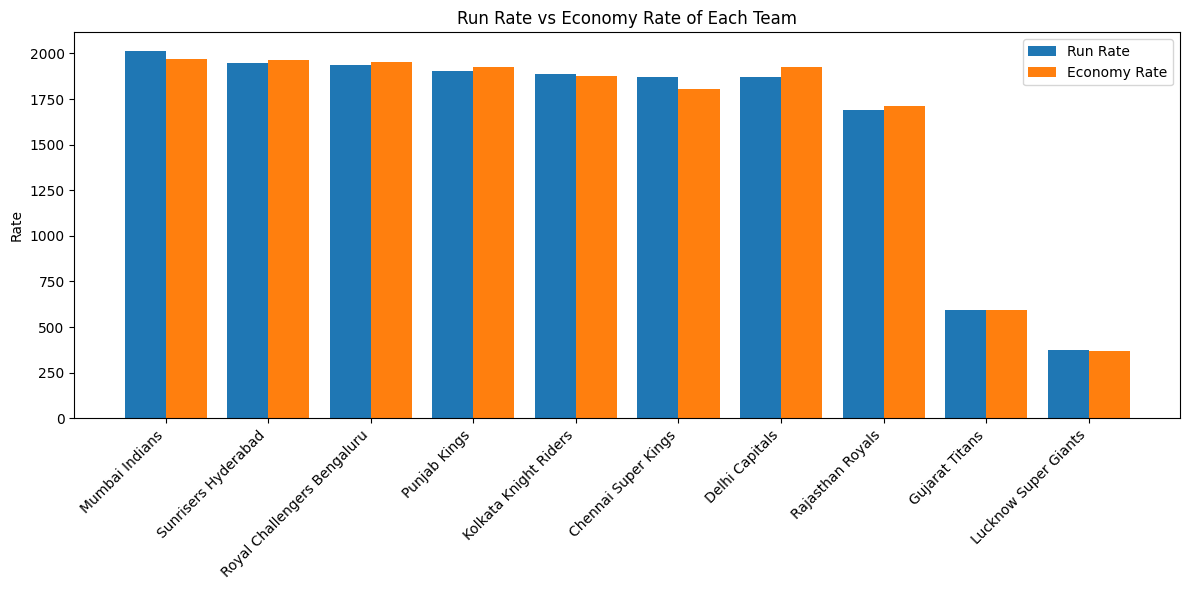

In [15]:
# Calculate Run Rate
team_runs = deliveries_df.groupby('batting_team')['total_runs'].sum()
team_overs = deliveries_df.groupby('batting_team')['over'].nunique()
team_run_rate = team_runs / team_overs

# Calculate Economy Rate
team_bowling_runs = deliveries_df.groupby('bowling_team')['total_runs'].sum()
team_bowling_overs = deliveries_df.groupby('bowling_team')['over'].nunique()
team_economy_rate = team_bowling_runs / team_bowling_overs

# Create DataFrame
team_rate_df = pd.DataFrame({
    'Run Rate': team_run_rate,
    'Economy Rate': team_economy_rate
}).reset_index().rename(columns={'index': 'Team'})

# Sorting based on Run Rate
team_rate_df.sort_values(by="Run Rate", ascending=False, inplace=True)
bar_width = 0.4
x = np.arange(len(team_rate_df))

color1 = "#1f77b4"  # Blue for Run Rate
color2 = "#ff7f0e"  # Orange for Economy Rate

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart for Run Rate
bars1 = ax.bar(x - bar_width/2, team_rate_df['Run Rate'], bar_width, label="Run Rate", color=color1)

# Bar chart for Economy Rate
bars2 = ax.bar(x + bar_width/2, team_rate_df['Economy Rate'], bar_width, label="Economy Rate", color=color2)

ax.set_xticks(x)
ax.set_xticklabels(team_rate_df['Team'], rotation=45, ha='right')
ax.set_ylabel("Rate")
ax.set_title("Run Rate vs Economy Rate of Each Team")
ax.legend()

plt.tight_layout()
plt.show()

## Key Takeaways
Balanced Teams: Most teams have similar Run Rate and Economy Rate, indicating a balanced performance in both batting and bowling.

High-Scoring Teams: Mumbai Indians, Sunrisers Hyderabad, and RCB have high Run Rates, suggesting aggressive batting.

Newer Teams Lag Behind: Gujarat Titans and Lucknow Super Giants have significantly lower values, likely due to fewer matches played compared to legacy teams.

### 3. Plotting Highest and Lowest Scores of each team

<Figure size 1400x700 with 0 Axes>

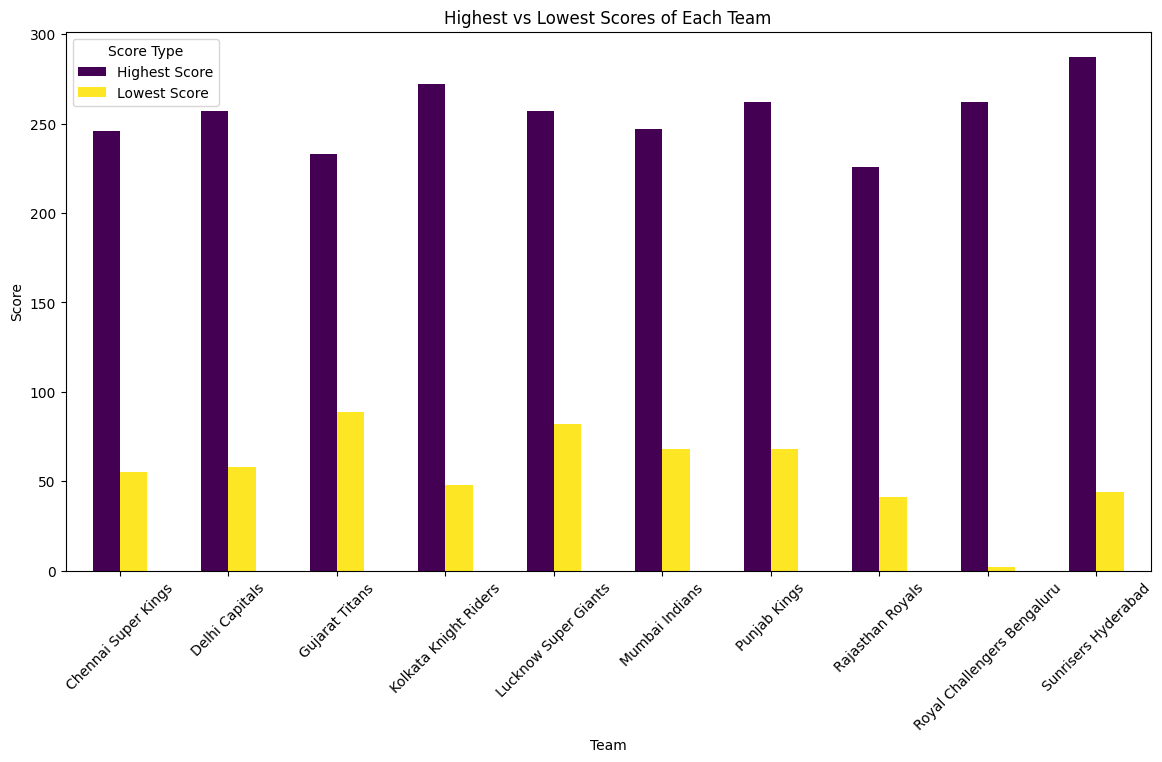

In [16]:
# Calculate highest and lowest scores for each team
highest_scores = deliveries_df.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
highest_scores = highest_scores.groupby('batting_team')['total_runs'].max().reset_index().rename(columns={'total_runs': 'Highest Score'})

lowest_scores = deliveries_df.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
lowest_scores = lowest_scores.groupby('batting_team')['total_runs'].min().reset_index().rename(columns={'total_runs': 'Lowest Score'})

# Merge into a single DataFrame
team_scores_df = pd.merge(highest_scores, lowest_scores, on='batting_team').rename(columns={'batting_team': 'Team'})

# Plot the combined bar chart
plt.figure(figsize=(14, 7))
team_scores_df.set_index('Team')[['Highest Score', 'Lowest Score']].plot(kind='bar', figsize=(14, 7), colormap='viridis')

# Labels and Title
plt.title('Highest vs Lowest Scores of Each Team')
plt.xlabel('Team')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Score Type')

plt.show()

## Key Takeaways
Sunrisers Hyderabad has the highest peak score, showcasing their explosive batting potential.

Some teams (eg, Mumbai Indians, Chennai Super Kings) have a smaller gap between highest and lowest scores, indicating more consistency.

Teams like RCB and KKR have both the highest scores and some of the lowest scores (RCB - 49 runs), highlighting their inconsistency.

### 4. Plotting Total 4s and 6s for each team


<Figure size 1400x700 with 0 Axes>

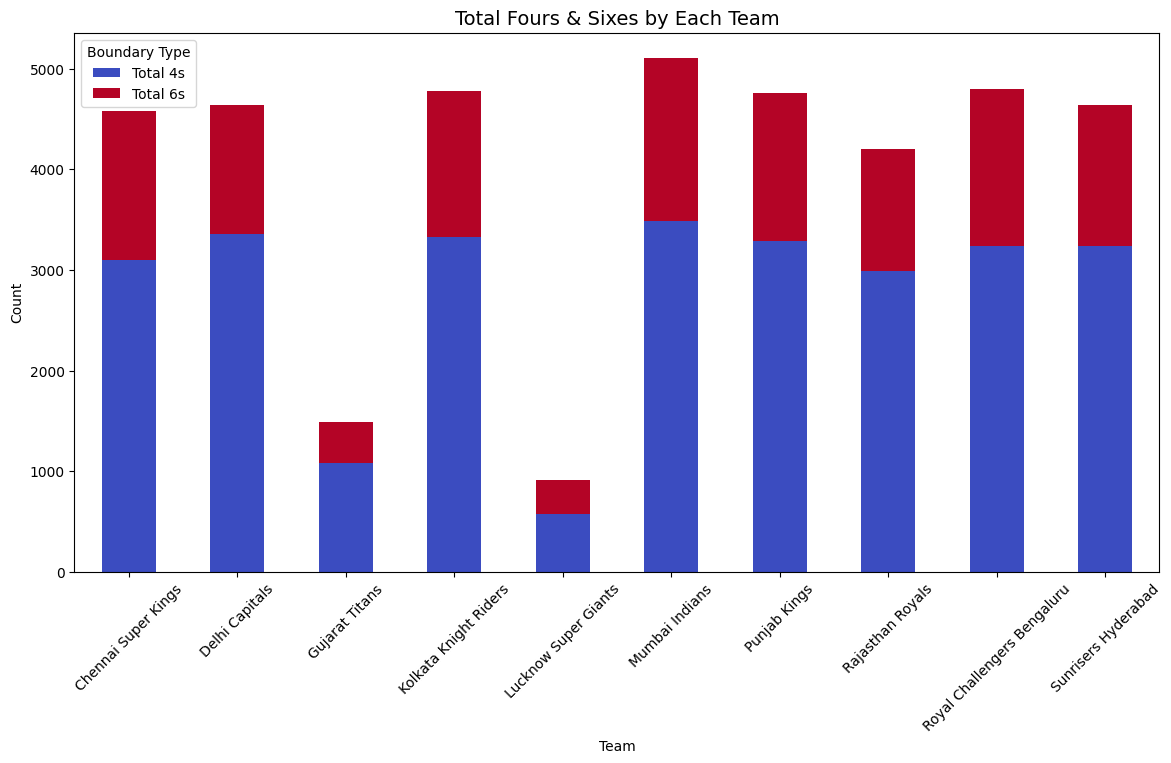

In [17]:
# Calculate total fours and sixes
total_fours = deliveries_df[deliveries_df['batsman_runs'] == 4].groupby('batting_team')['batsman_runs'].count().reset_index().rename(columns={'batsman_runs': 'Total 4s'})
total_sixes = deliveries_df[deliveries_df['batsman_runs'] == 6].groupby('batting_team')['batsman_runs'].count().reset_index().rename(columns={'batsman_runs': 'Total 6s'})

team_boundaries_df = pd.merge(total_fours, total_sixes, on='batting_team').rename(columns={'batting_team': 'Team'})

# Plot stacked bar chart
plt.figure(figsize=(14, 7))
team_boundaries_df.set_index('Team')[['Total 4s', 'Total 6s']].plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 7))

plt.title('Total Fours & Sixes by Each Team', fontsize=14)
plt.xlabel('Team')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Boundary Type')

plt.show()

## Key Takeaways
Teams like RCB and MI dominate in both fours and sixes, indicating a strong power-hitting lineup.

Some teams rely more on sixes than fours (eg, KKR, CSK), suggesting an aggressive batting approach.

A balanced number of boundaries (fours + sixes) is crucial for consistent high scores, as seen with MI.

### 5. Plotting Average Powerplay and Death Overs Score for each team


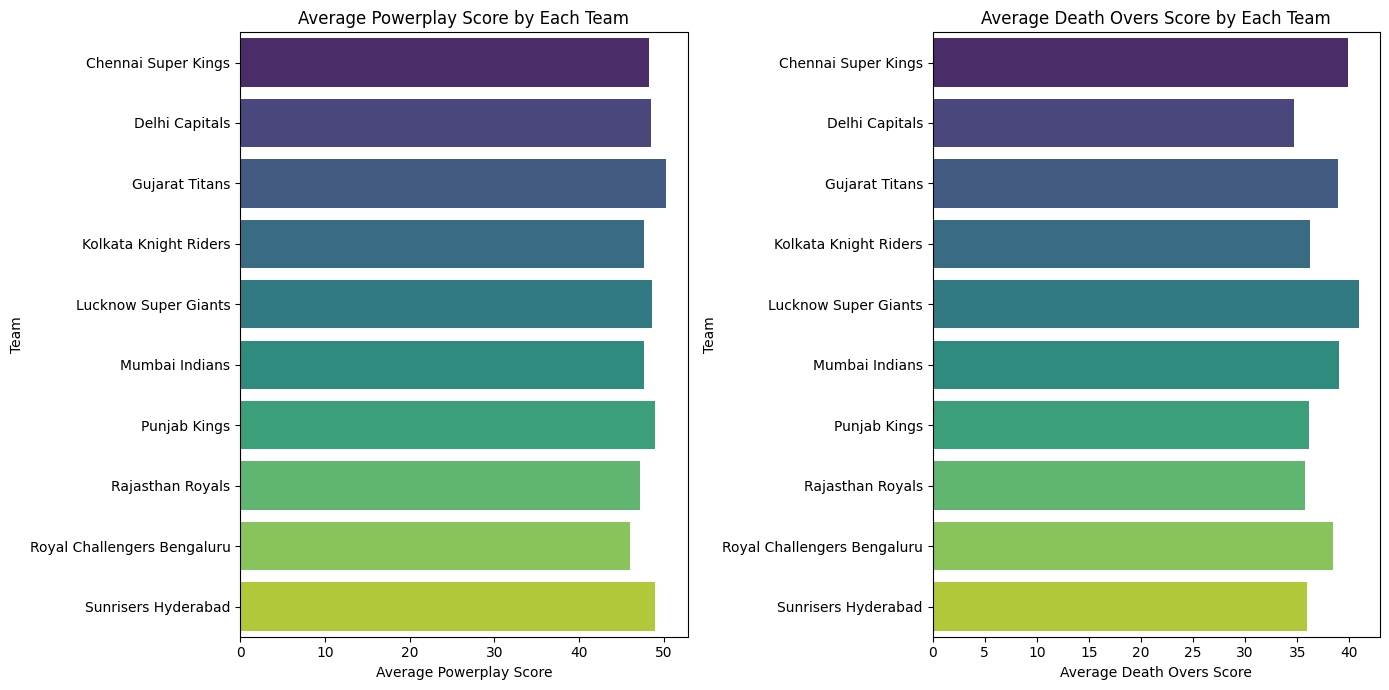

In [18]:
powerplay_scores = deliveries_df[(deliveries_df['over'] >= 1) & (deliveries_df['over'] <= 6)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
death_overs_scores = deliveries_df[(deliveries_df['over'] >= 16) & (deliveries_df['over'] <= 20)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

average_powerplay_scores = powerplay_scores.groupby('batting_team')['total_runs'].mean().reset_index().rename(columns={'total_runs': 'Average Powerplay Score'})
average_death_overs_scores = death_overs_scores.groupby('batting_team')['total_runs'].mean().reset_index().rename(columns={'total_runs': 'Average Death Overs Score'})

# Merge average powerplay and death overs scores into a single DataFrame
team_overs_scores_df = pd.merge(average_powerplay_scores, average_death_overs_scores, on='batting_team').rename(columns={'batting_team': 'Team'})

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='Average Powerplay Score', y='Team', data=team_overs_scores_df, palette='viridis')
plt.title('Average Powerplay Score by Each Team')
plt.xlabel('Average Powerplay Score')
plt.ylabel('Team')

plt.subplot(1, 2, 2)
sns.barplot(x='Average Death Overs Score', y='Team', data=team_overs_scores_df, palette='viridis')
plt.title('Average Death Overs Score by Each Team')
plt.xlabel('Average Death Overs Score')
plt.ylabel('Team')


plt.tight_layout()
plt.show()

## Key Takeaways
Some teams start aggressively in the powerplay with higher scores, while others prefer a cautious approach, relying more on the death overs to accelerate.

Teams with a significantly higher average death overs score tend to have strong finishers who can capitalize on the last few overs, boosting their overall total.

Some teams maintain consistency across both phases, while others specialize in either early domination or late acceleration, affecting their overall batting strategy.

### 6. Powerplay Analysis


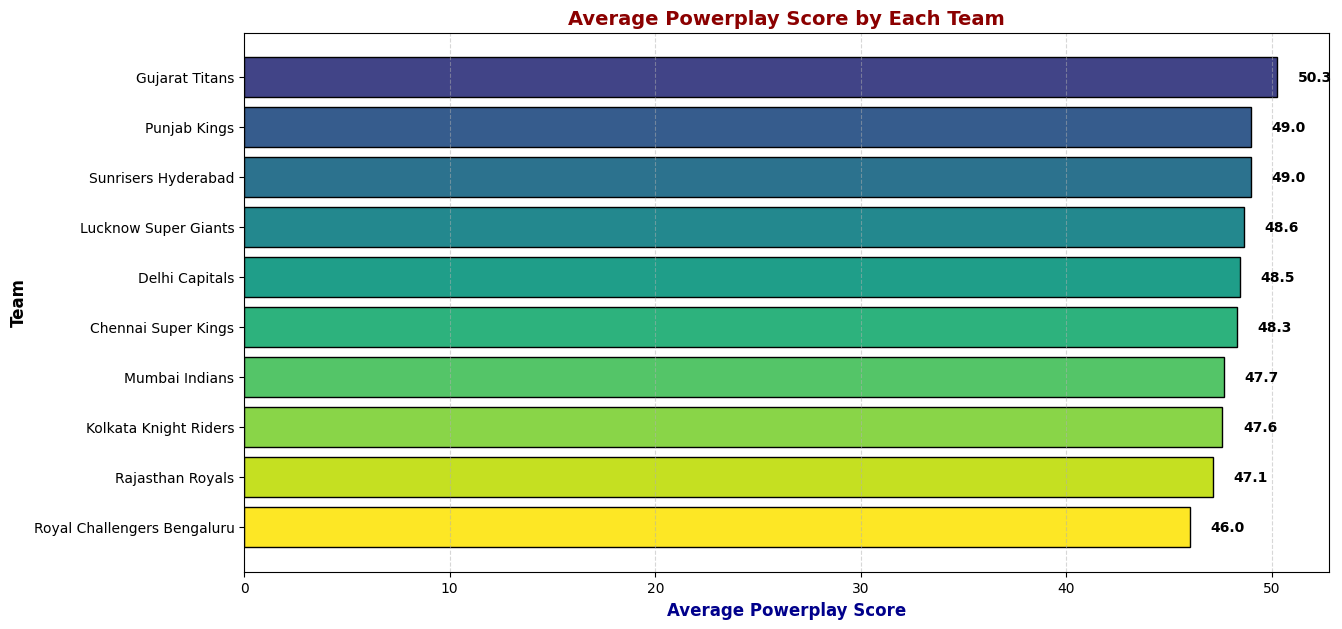

In [23]:
# Renaming columns for clarity
average_powerplay_scores = average_powerplay_scores.rename(columns={"batting_team": "Team"})

# Sort teams by Average Powerplay Score
average_powerplay_scores = average_powerplay_scores.sort_values(by="Average Powerplay Score", ascending=False)

fig, ax = plt.subplots(figsize=(14, 7))
y_positions = np.arange(len(average_powerplay_scores))
colors = plt.cm.viridis(np.linspace(0.2, 1, len(average_powerplay_scores)))
bars = ax.barh(average_powerplay_scores["Team"], average_powerplay_scores["Average Powerplay Score"], color=colors, edgecolor="black")

# Add value labels on bars
for bar in bars:
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.1f}", va='center', fontsize=10, fontweight="bold")

ax.set_xlabel("Average Powerplay Score", fontsize=12, fontweight="bold", color="darkblue")
ax.set_ylabel("Team", fontsize=12, fontweight="bold")
ax.set_title("Average Powerplay Score by Each Team", fontsize=14, fontweight="bold", color="darkred")

ax.invert_yaxis()
ax.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

## Key Takeaways
Gujarat Titans lead with the highest average powerplay score (50.3), indicating an aggressive and effective top order.

Punjab Kings (49.0) and Sunrisers Hyderabad (49.0) are not far behind, showing a similar attacking approach.

Lucknow Super Giants (48.6) and Delhi Capitals (48.5) also maintain strong starts.

Chennai Super Kings, Mumbai Indians, and Kolkata Knight Riders have moderate powerplay scores (~47-48), balancing attack with caution.

Rajasthan Royals (47.1) and RCB (46.0) score the lowest, indicating either a cautious approach or early wickets affecting scoring rates.

Now let's analyse the player performances in matches.
## Player Performance

### 1. Top 20 run-scorers

Top 20 Run-Scorers in IPL:
            Batter  Total Runs
0          V Kohli        7565
1         S Dhawan        6546
2        DA Warner        6339
3        RG Sharma        6317
4         SK Raina        5239
5   AB de Villiers        4862
6         KL Rahul        4644
7       KD Karthik        4571
8         CH Gayle        4570
9         MS Dhoni        4511
10       SV Samson        4275
11    F du Plessis        4256
12       AT Rayudu        4137
13       G Gambhir        3935
14      RV Uthappa        3760
15       AM Rahane        3599
16       SR Watson        3595
17        SA Yadav        3504
18      JC Buttler        3501
19      KA Pollard        3331


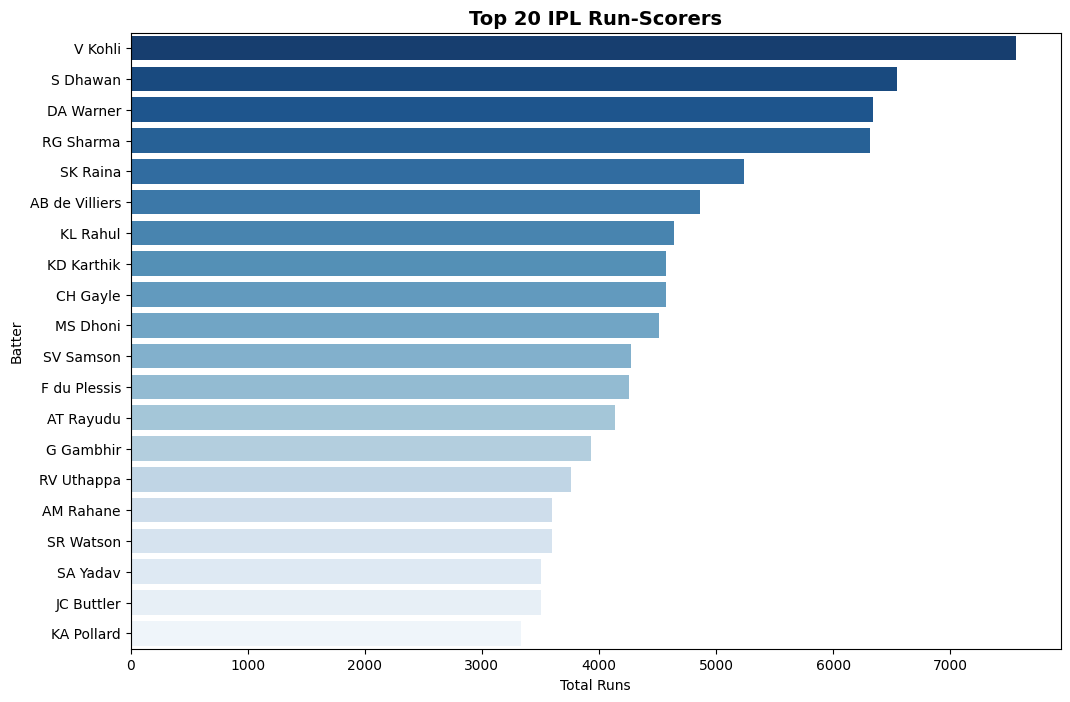

In [25]:
# Calculate total runs scored by each player
top_run_scorers = deliveries_df.groupby('batter')['batsman_runs'].sum().reset_index()

# Sort the players by total runs in descending order and get the top 20
top_20_run_scorers = top_run_scorers.sort_values(by='batsman_runs', ascending=False).head(20)
top_20_run_scorers = top_20_run_scorers.rename(columns={'batter': 'Batter', 'batsman_runs': 'Total Runs'})
top_20_run_scorers = top_20_run_scorers.reset_index(drop=True)

print("Top 20 Run-Scorers in IPL:")
print(top_20_run_scorers)

import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Total Runs', y='Batter', data=top_20_run_scorers, palette='Blues_r')

plt.title('Top 20 IPL Run-Scorers', fontsize=14, fontweight='bold')
plt.xlabel('Total Runs')
plt.ylabel('Batter')
plt.show()

## Key Takeaways
With 7,565 runs, Virat Kohli leads by a significant margin. His consistency and adaptability across IPL seasons are unmatched.

14 out of the 20 top run-scorers are Indian players. This highlights how Indian players get consistent opportunities, play more games, and adapt well to the league.

The presence of Shikhar Dhawan, David Warner, Chris Gayle, and Gautam Gambhir shows the dominance of left-handed openers in IPL history.

### 2. Plotting Batting Average vs Batting Strike Rate for the top 20 run-scorers


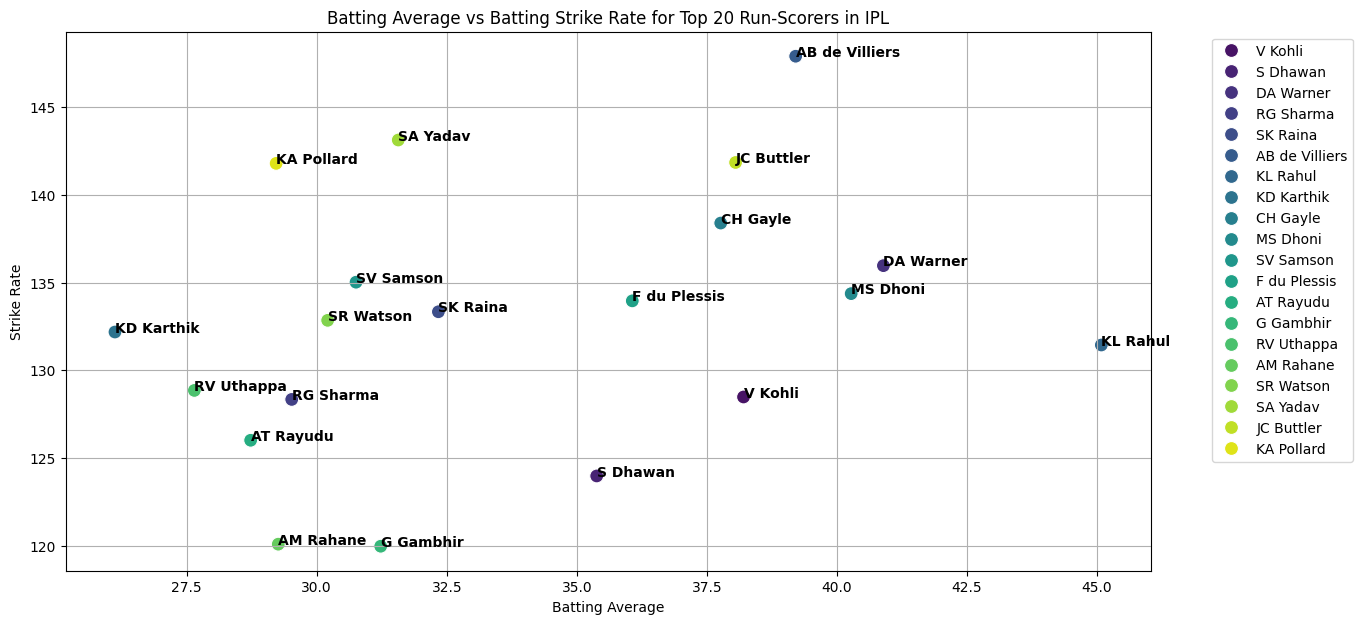

In [26]:
# Calculate total runs scored by each player
total_runs = deliveries_df.groupby('batter')['batsman_runs'].sum().reset_index()

# Calculate total balls faced by each player
total_balls = deliveries_df.groupby('batter')['ball'].count().reset_index()

# Calculate total dismissals for each player
total_dismissals = deliveries_df[deliveries_df['is_wicket'] == 1].groupby('player_dismissed')['is_wicket'].count().reset_index()

# Merge total runs, total balls, and total dismissals into a single DataFrame
player_stats = pd.merge(total_runs, total_balls, on='batter')
player_stats = pd.merge(player_stats, total_dismissals, left_on='batter', right_on='player_dismissed', how='left').fillna(0)

# Calculate batting average and strike rate
player_stats['batting_average'] = player_stats['batsman_runs'] / player_stats['is_wicket']
player_stats['strike_rate'] = (player_stats['batsman_runs'] / player_stats['ball']) * 100

# Sort the players by total runs in descending order and get the top 20
top_20_run_scorers = player_stats.sort_values(by='batsman_runs', ascending=False).head(20)

# Plotting Batting Average vs Batting Strike Rate for the top 20 run-scorers
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(x='batting_average', y='strike_rate', data=top_20_run_scorers, hue='batter', palette='viridis', s=100)

# Add labels to each point
for line in range(0, top_20_run_scorers.shape[0]):
    scatter_plot.text(top_20_run_scorers.batting_average.iloc[line], top_20_run_scorers.strike_rate.iloc[line],
                      top_20_run_scorers.batter.iloc[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Batting Average vs Batting Strike Rate for Top 20 Run-Scorers in IPL')
plt.xlabel('Batting Average')
plt.ylabel('Strike Rate')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Key Takeaways
AB de Villiers, Jos Buttler, and Kieron Pollard are among the most explosive batters, maintaining high strike rates (above 140) while still contributing significant runs, making them key finishers.

KL Rahul and Virat Kohli focus more on consistency, with high batting averages but relatively lower strike rates, indicating their role as anchors rather than aggressive hitters.

David Warner and MS Dhoni strike a balance between aggression and consistency, with Warner excelling as a top-order batter and Dhoni playing a calculated finisher’s role.

### 3. Finding Highest Average and Strike Rate for players with >50 matches


In [27]:
# Calculate total runs scored by each player
total_runs = deliveries_df.groupby('batter')['batsman_runs'].sum().reset_index()

# Calculate total balls faced by each player
total_balls = deliveries_df.groupby('batter')['ball'].count().reset_index()

# Calculate total dismissals for each player
total_dismissals = deliveries_df[deliveries_df['is_wicket'] == 1].groupby('player_dismissed')['is_wicket'].count().reset_index()

# Calculate total matches played by each player
total_matches = deliveries_df.groupby('batter')['match_id'].nunique().reset_index()

# Merge total runs, total balls, total dismissals, and total matches into a single DataFrame
player_stats = pd.merge(total_runs, total_balls, on='batter')
player_stats = pd.merge(player_stats, total_dismissals, left_on='batter', right_on='player_dismissed', how='left').fillna(0)
player_stats = pd.merge(player_stats, total_matches, on='batter')

# Rename columns for clarity
player_stats = player_stats.rename(columns={'batter': 'Batter', 'batsman_runs': 'Total Runs', 'ball': 'Total Balls', 'is_wicket': 'Total Dismissals', 'match_id': 'Total Matches'})

# Calculate batting average and strike rate
player_stats['Batting Average'] = player_stats['Total Runs'] / player_stats['Total Dismissals']
player_stats['Strike Rate'] = (player_stats['Total Runs'] / player_stats['Total Balls']) * 100

# Filter players with more than 50 matches
players_gt_50_matches = player_stats[player_stats['Total Matches'] > 50]

# Find the player with the highest batting average
highest_average_player = players_gt_50_matches.loc[players_gt_50_matches['Batting Average'].idxmax()]

# Find the player with the highest strike rate
highest_strike_rate_player = players_gt_50_matches.loc[players_gt_50_matches['Strike Rate'].idxmax()]

print("Player with the Highest Batting Average (more than 50 matches):")
print(highest_average_player[['Batter', 'Batting Average']])

print("\nPlayer with the Highest Strike Rate (more than 50 matches):")
print(highest_strike_rate_player[['Batter', 'Strike Rate']])

Player with the Highest Batting Average (more than 50 matches):
Batter              KL Rahul
Batting Average    45.087379
Name: 282, dtype: object

Player with the Highest Strike Rate (more than 50 matches):
Batter         AD Russell
Strike Rate    164.404524
Name: 38, dtype: object


KL Rahul dominates the Highest Batting Average while AD Russell leads in the Highest Strike Rate.

### 4. Plotting top wicket-takers


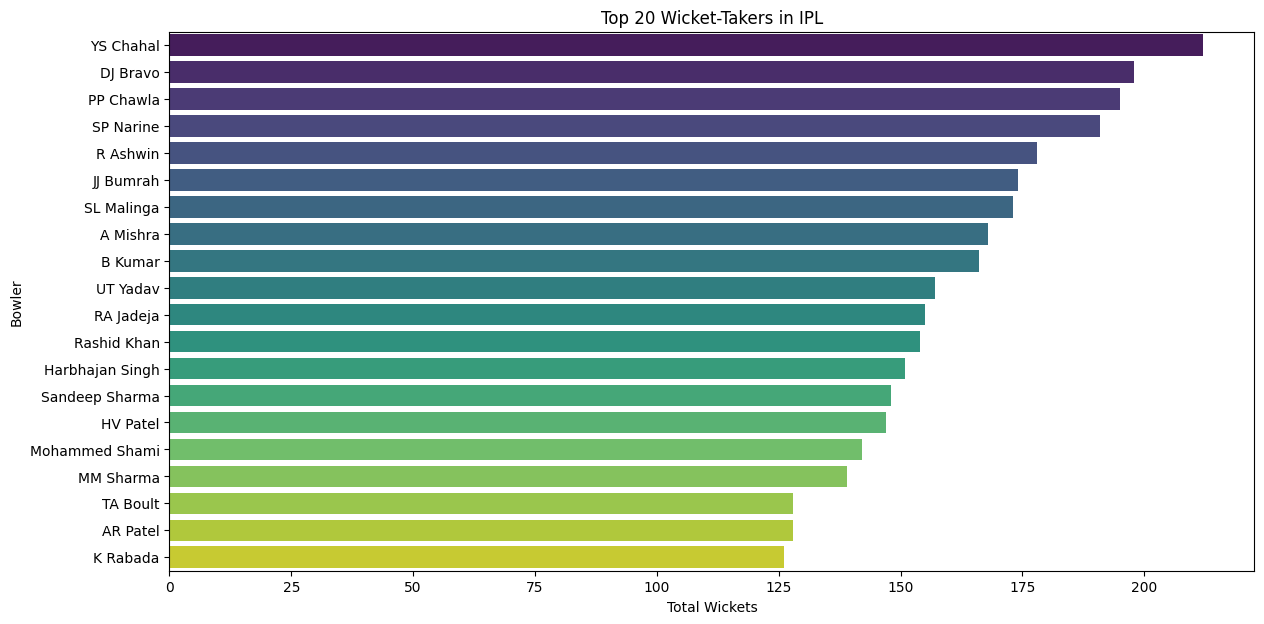

In [28]:
# Calculate total wickets taken by each bowler
total_wickets = deliveries_df[deliveries_df['is_wicket'] == 1].groupby('bowler')['is_wicket'].count().reset_index()

# Sort the bowlers by total wickets in descending order and get the top 20
top_wicket_takers = total_wickets.sort_values(by='is_wicket', ascending=False).head(20)

# Rename the columns for clarity
top_wicket_takers = top_wicket_takers.rename(columns={'bowler': 'Bowler', 'is_wicket': 'Total Wickets'})

# Plotting the top wicket-takers
plt.figure(figsize=(14, 7))
sns.barplot(x='Total Wickets', y='Bowler', data=top_wicket_takers, palette='viridis')
plt.title('Top 20 Wicket-Takers in IPL')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.show()

## Key Takeaways
Yuzvendra Chahal and Dwayne Bravo lead the charts, highlighting their consistent wicket-taking ability across multiple IPL seasons, with Chahal excelling as a leg-spinner and Bravo as a death-over specialist.

A strong presence of spinners like Piyush Chawla, Sunil Narine, and Ravichandran Ashwin indicates the crucial role spin bowling plays in IPL, especially in middle overs where they control the game and break partnerships.

Pace bowlers like Jasprit Bumrah, Lasith Malinga, and Bhuvneshwar Kumar remain key assets, excelling in both powerplay and death overs, showcasing the importance of fast bowling in T20 cricket.

### 5. Plotting top highest individual scores


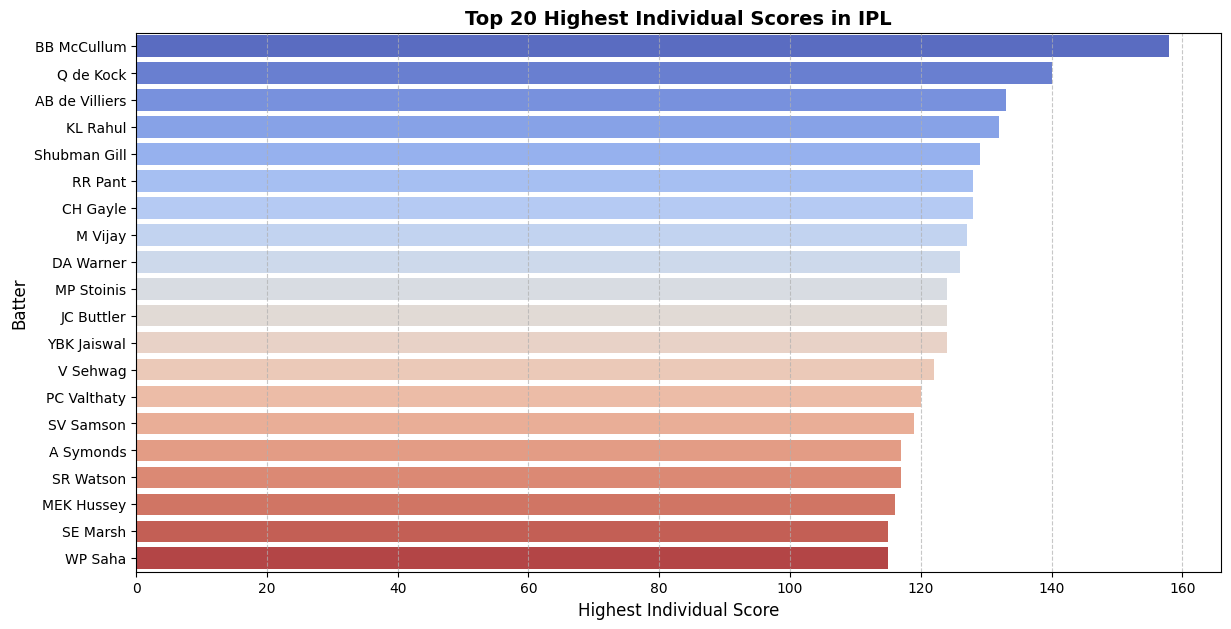

In [29]:
# Calculate the highest individual scores by each player in a single match
highest_individual_scores = deliveries_df.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()

# Get the highest score for each player
highest_individual_scores = highest_individual_scores.groupby('batter')['batsman_runs'].max().reset_index()

# Sort the players by highest individual score in descending order and get the top 20
top_highest_individual_scores = highest_individual_scores.sort_values(by='batsman_runs', ascending=False).head(20)

# Rename the columns for clarity
top_highest_individual_scores = top_highest_individual_scores.rename(columns={'batter': 'Batter', 'batsman_runs': 'Highest Individual Score'})

plt.figure(figsize=(14, 7))
# Create the barplot with improved colors
sns.barplot(x='Highest Individual Score', y='Batter', data=top_highest_individual_scores, palette='coolwarm')

plt.title('Top 20 Highest Individual Scores in IPL', fontsize=14, fontweight='bold')
plt.xlabel('Highest Individual Score', fontsize=12)
plt.ylabel('Batter', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Key Takeaways
Brendon McCullum holds the highest individual score in IPL history, reflecting his explosive batting style in the league's early years.

Recent stars like Quinton de Kock, KL Rahul, and Shubman Gill have also recorded massive individual scores, showing that high-scoring innings are becoming more frequent in modern IPL seasons.

Veteran players like Chris Gayle, David Warner, and AB de Villiers feature prominently, reinforcing the dominance of aggressive batsmen across different IPL eras.

### 6. Man of the Match Count Analysis


Man of the Match DataFrame:
            Player  No. of matches
0   AB de Villiers              22
1         CH Gayle              18
2        RG Sharma              17
3        DA Warner              17
4          V Kohli              16
5        RA Jadeja              16
6       AD Russell              15
7        SR Watson              15
8        SP Narine              14
9       KA Pollard              14
10        MS Dhoni              14
11        SK Raina              14
12       YK Pathan              14
13      JC Buttler              13
14        KL Rahul              13
15       G Gambhir              12
16        S Dhawan              12
17     Rashid Khan              12
18      MEK Hussey              11
19      RD Gaikwad              11


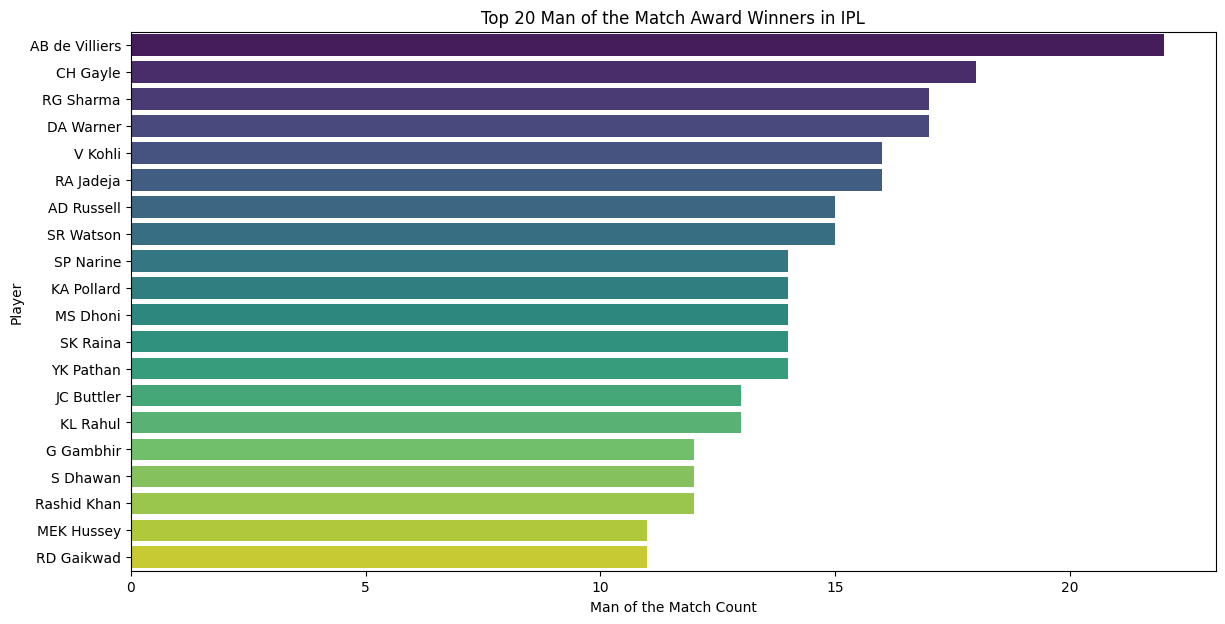

In [30]:
# Calculate the number of Man of the Match awards won by each player
man_of_the_match_counts = matches_df['player_of_match'].value_counts().reset_index()
man_of_the_match_counts = man_of_the_match_counts.rename(columns={'player_of_match': 'Player', 'count': 'No. of matches'})

# Print the exact DataFrame to see column structure
print("Man of the Match DataFrame:")
print(man_of_the_match_counts.head(20))

# Plot using the actual column names without assuming what they are
plt.figure(figsize=(14, 7))
sns.barplot(
    x=man_of_the_match_counts.columns[1],  # Count column (second column)
    y=man_of_the_match_counts.columns[0],  # Player name column (first column)
    data=man_of_the_match_counts.head(20),
    palette='viridis'
)
plt.title('Top 20 Man of the Match Award Winners in IPL')
plt.xlabel('Man of the Match Count')
plt.ylabel('Player')
plt.show()

## Key Takeaways
AB de Villiers leads the list, showcasing his match-winning ability—a testament to his explosive batting and clutch performances.

Chris Gayle, Rohit Sharma, and David Warner follow closely, indicating that power-hitters and consistent performers dominate IPL's history.

All-rounders like Andre Russell, Ravindra Jadeja, and Sunil Narine feature prominently, proving their impact with both bat and ball.

MS Dhoni and Virat Kohli make the list, reflecting their leadership and batting prowess in crucial moments.

### 7. Using K-Means Clustering to plot Batting Average vs Bowling Economy Rate for number of clusters = 3 (Batsman, Bowler, All Rounder)


Cluster centroids:
Cluster 0: Batting Avg = 8.29, Economy Rate = 8.02
Cluster 1: Batting Avg = 27.13, Economy Rate = 8.36
Cluster 2: Batting Avg = 10.91, Economy Rate = 10.91


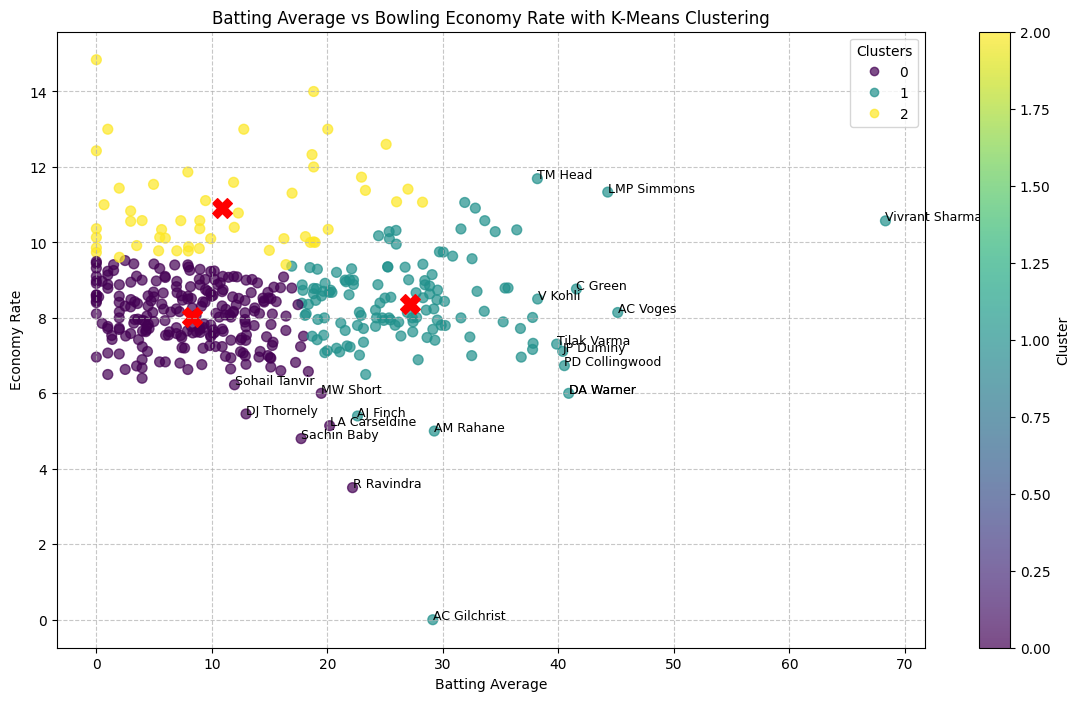

In [31]:
# Calculate batting statistics for each player
# Total runs scored by each batsman
batting_runs = deliveries_df.groupby('batter')['batsman_runs'].sum().reset_index()

# Total dismissals for each batsman
batting_dismissals = deliveries_df[deliveries_df['is_wicket'] == 1].groupby('player_dismissed')['is_wicket'].count().reset_index()

# Merge runs and dismissals
batting_stats = pd.merge(batting_runs, batting_dismissals, left_on='batter', right_on='player_dismissed', how='left')
batting_stats = batting_stats.rename(columns={'batter': 'player', 'batsman_runs': 'total_runs', 'is_wicket': 'dismissals'})
batting_stats['dismissals'] = batting_stats['dismissals'].fillna(0)

# Calculate batting average (add small value to avoid division by zero)
batting_stats['batting_average'] = batting_stats['total_runs'] / (batting_stats['dismissals'] + 0.01)

# Calculate bowling statistics for each player
bowling_runs = deliveries_df.groupby('bowler')['total_runs'].sum().reset_index()

# Total balls bowled by each bowler
bowling_balls = deliveries_df.groupby('bowler')['ball'].count().reset_index()

# Merge runs and balls
bowling_stats = pd.merge(bowling_runs, bowling_balls, on='bowler')
bowling_stats = bowling_stats.rename(columns={'bowler': 'player', 'total_runs': 'runs_conceded', 'ball': 'balls_bowled'})

# Calculate economy rate (runs conceded per over)
bowling_stats['overs_bowled'] = bowling_stats['balls_bowled'] / 6
bowling_stats['economy_rate'] = bowling_stats['runs_conceded'] / bowling_stats['overs_bowled']

# Merge batting and bowling stats
player_stats = pd.merge(batting_stats[['player', 'batting_average']],
                        bowling_stats[['player', 'economy_rate']],
                        on='player',
                        how='inner')

# Filter out players with extreme values for better visualization
player_stats = player_stats[(player_stats['batting_average'] < 100) &
                           (player_stats['economy_rate'] < 15)]

# Apply K-means clustering
X = player_stats[['batting_average', 'economy_rate']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
player_stats['cluster'] = kmeans.fit_predict(X_scaled)

# Define cluster labels
cluster_labels = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2'
}

# We'll determine which is which based on centroid locations
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: Batting Avg = {centroid[0]:.2f}, Economy Rate = {centroid[1]:.2f}")

# Assign meaningful labels based on centroid values:
# High batting avg, high economy = Batsman
# Low batting avg, low economy = Bowler
# Medium batting avg, medium economy = All-Rounder
# But we'll check the actual centroids to confirm

# Plot the clusters
plt.figure(figsize=(14, 8))
scatter = plt.scatter(player_stats['batting_average'],
                     player_stats['economy_rate'],
                     c=player_stats['cluster'],
                     cmap='viridis',
                     s=50,
                     alpha=0.7)

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

for i, player in enumerate(player_stats.nlargest(10, 'batting_average')['player']):
    plt.annotate(player,
                 (player_stats.loc[player_stats['player'] == player, 'batting_average'].values[0],
                  player_stats.loc[player_stats['player'] == player, 'economy_rate'].values[0]),
                 fontsize=9)

for i, player in enumerate(player_stats.nsmallest(10, 'economy_rate')['player']):
    plt.annotate(player,
                 (player_stats.loc[player_stats['player'] == player, 'batting_average'].values[0],
                  player_stats.loc[player_stats['player'] == player, 'economy_rate'].values[0]),
                 fontsize=9)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Batting Average vs Bowling Economy Rate with K-Means Clustering')
plt.xlabel('Batting Average')
plt.ylabel('Economy Rate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.show()


## Key Takeaways
Cluster 0 (Purple) - Low Batting Avg, Moderate Economy Rate (Avg: 8.29, 8.02)

- This cluster likely consists of specialist bowlers with low batting averages and a reasonable economy rate.

- Players like Sohail Tanvir and J Thornely belong here, indicating they are primarily bowlers with minimal batting contributions.

Cluster 1 (Teal) - High Batting Avg, Moderate Economy Rate (Avg: 27.13, 8.36)

- Likely top-order batters or all-rounders who have solid batting averages but occasionally bowl.

- Big names like Virat Kohli, DA Warner, and Tilak Varma belong here, suggesting these players are consistent batsmen.

Cluster 2 (Yellow) - Low Batting Avg, High Economy Rate (Avg: 10.91, 10.91)

- Likely consists of expensive bowlers with high economy rates.

- Many scattered points at high economy rates (>10) suggest these bowlers leak runs and don't contribute much with the bat.

### 8. Identifing top 10 batsmen in each category
- Top 6's Scorer
- Top 4's Scorer
- Top 2's scorer
- Top 1's scorer

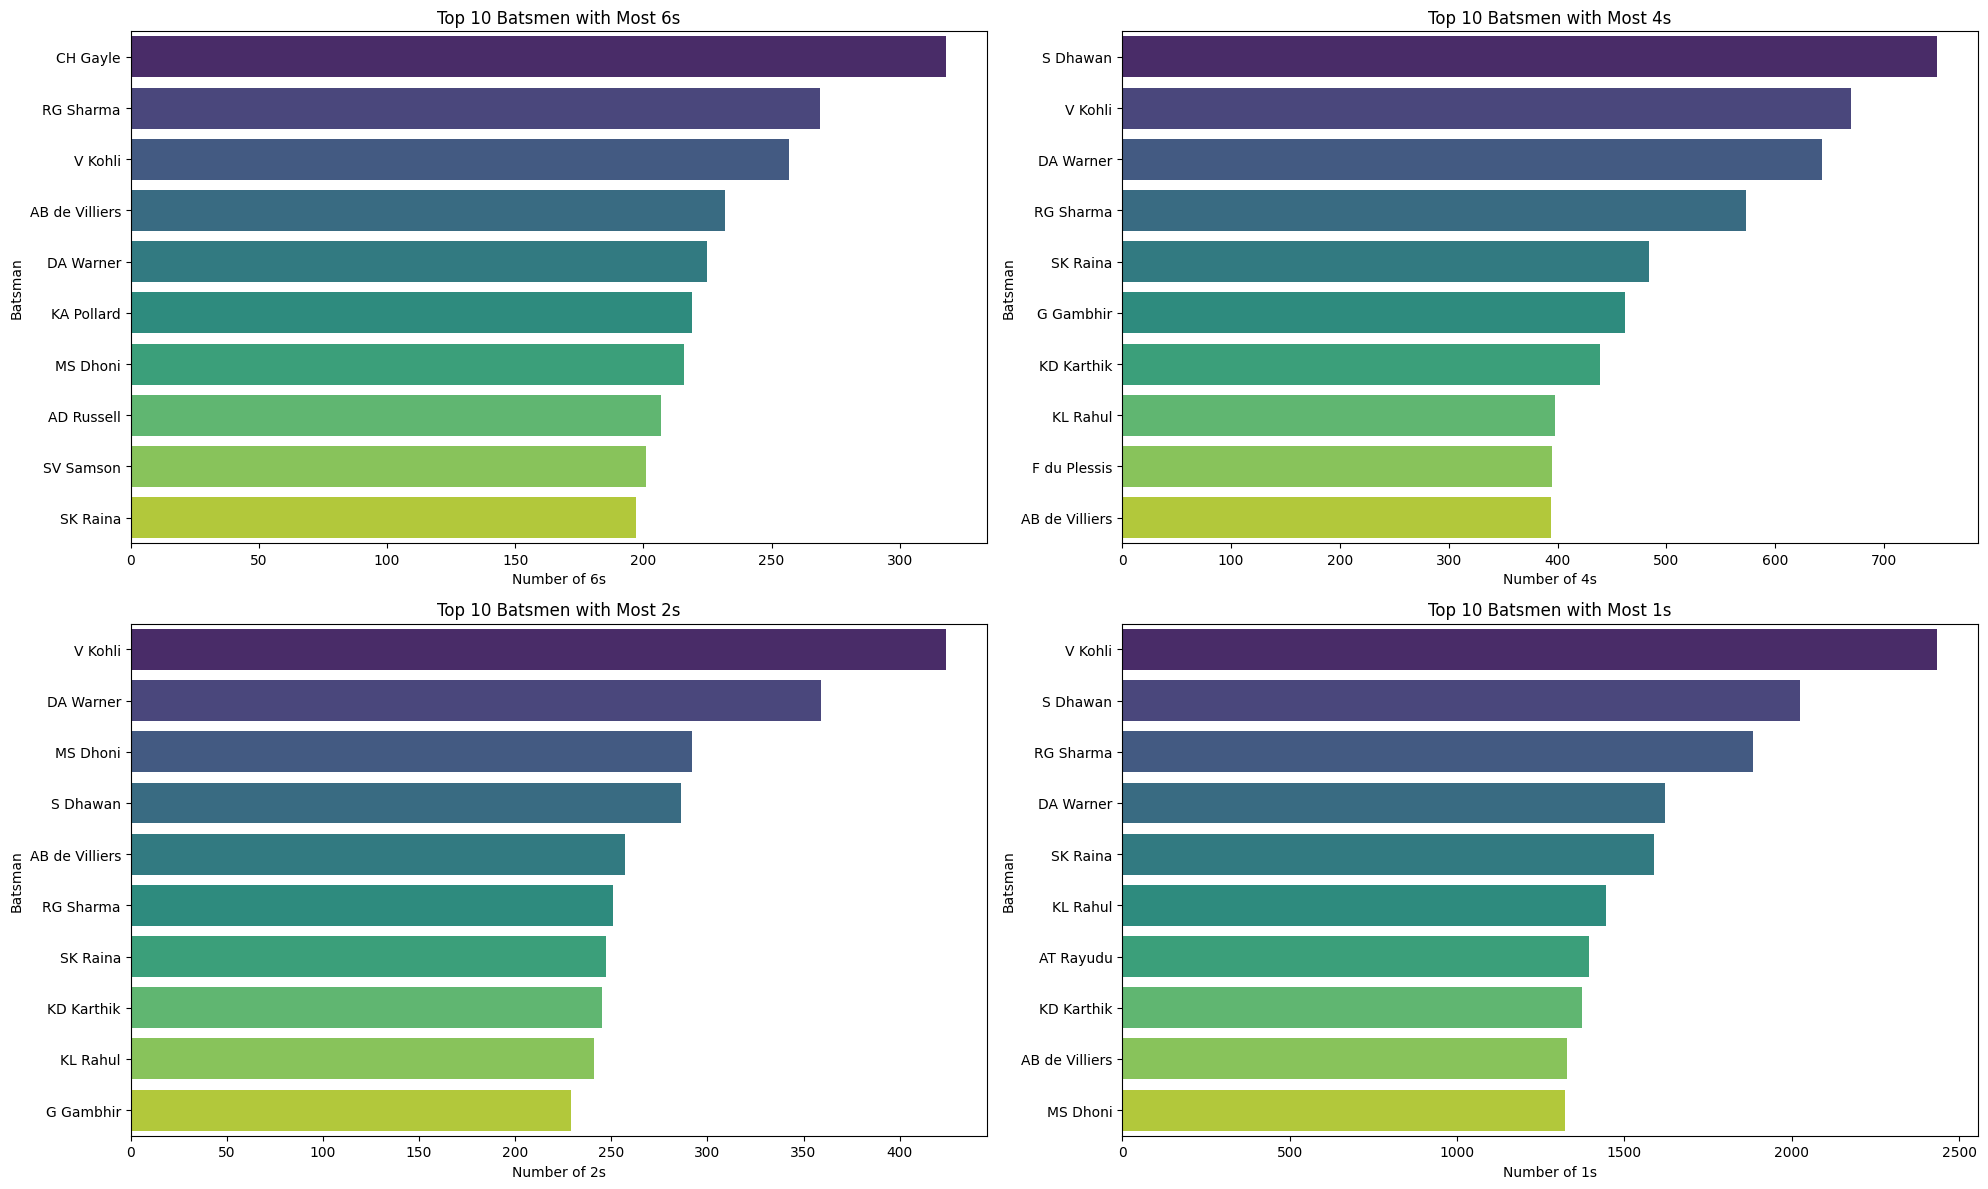

In [34]:
# Create functions to get top batsmen for each run category
def get_top_scorers(df, run_value):
    # Filter deliveries by run value
    run_df = df[df['batsman_runs'] == run_value]

    # Count occurrences for each batsman
    batsmen_counts = run_df.groupby('batter')['batsman_runs'].count().reset_index()

    # Rename columns
    batsmen_counts = batsmen_counts.rename(columns={'batter': 'Batsman', 'batsman_runs': f'Number of {run_value}s'})

    # Sort and get top 10
    return batsmen_counts.sort_values(by=f'Number of {run_value}s', ascending=False).head(10)

# Get top 10 batsmen for each run category
top_six_hitters = get_top_scorers(deliveries_df, 6)
top_four_hitters = get_top_scorers(deliveries_df, 4)
top_two_scorers = get_top_scorers(deliveries_df, 2)
top_one_scorers = get_top_scorers(deliveries_df, 1)

# Create plots for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot Top 6's scorers
sns.barplot(x='Number of 6s', y='Batsman', data=top_six_hitters, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Top 10 Batsmen with Most 6s')
axes[0, 0].set_ylabel('Batsman')
axes[0, 0].set_xlabel('Number of 6s')

# Plot Top 4's scorers
sns.barplot(x='Number of 4s', y='Batsman', data=top_four_hitters, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Batsmen with Most 4s')
axes[0, 1].set_ylabel('Batsman')
axes[0, 1].set_xlabel('Number of 4s')

# Plot Top 2's scorers
sns.barplot(x='Number of 2s', y='Batsman', data=top_two_scorers, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Batsmen with Most 2s')
axes[1, 0].set_ylabel('Batsman')
axes[1, 0].set_xlabel('Number of 2s')

# Plot Top 1's scorers
sns.barplot(x='Number of 1s', y='Batsman', data=top_one_scorers, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Top 10 Batsmen with Most 1s')
axes[1, 1].set_ylabel('Batsman')
axes[1, 1].set_xlabel('Number of 1s')

plt.tight_layout()
plt.show()


Let us now look at the Seasonal Analysis and identify key trends.
## Seasonal Analysis

### 1. Calculate average runs per match per season


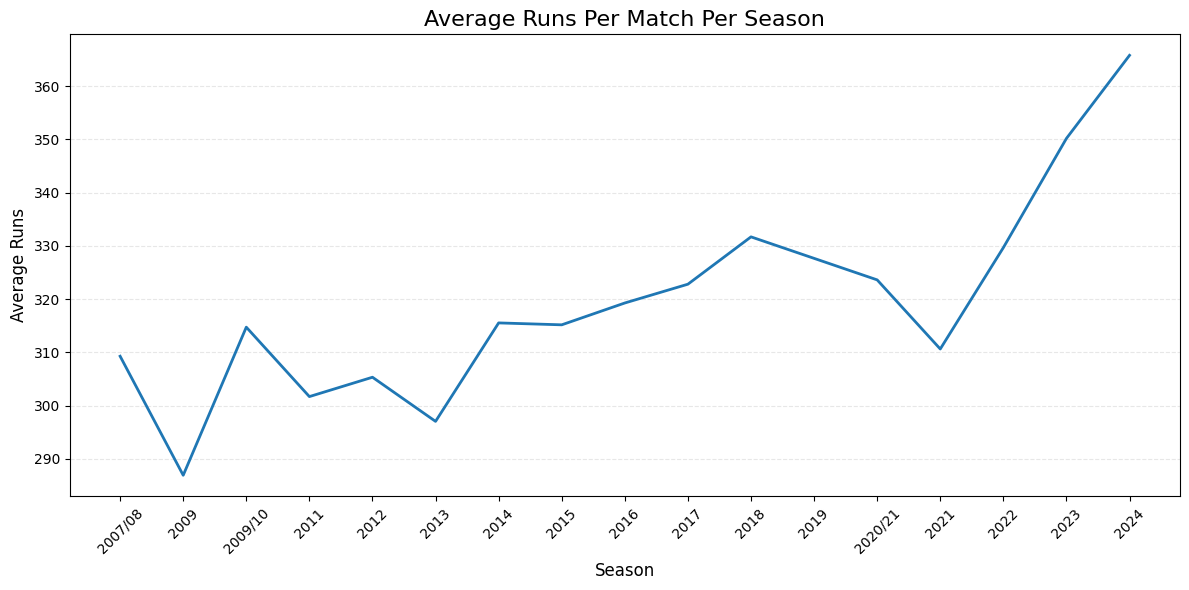

In [35]:
# Calculate total runs scored in each match
match_runs = deliveries_df.groupby('match_id')['total_runs'].sum().reset_index()

# Merge with matches data to get season information
match_runs_season = match_runs.merge(matches_df[['id', 'season']], left_on='match_id', right_on='id')

# Calculate average runs per match per season
avg_runs_per_season = match_runs_season.groupby('season')['total_runs'].mean().reset_index()

# Visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x='season', y='total_runs', data=avg_runs_per_season, palette='viridis', markers='o', linewidth=2)
plt.title('Average Runs Per Match Per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Runs', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Key Takeaways
The average runs per match have increased over the seasons, especially in the later years, indicating a more aggressive style of play or improved batting conditions.

There are notable ups and downs in the earlier seasons, suggesting variability in playing conditions, team strategies, or even rule changes.

The last few seasons show a sharp rise in the average runs per match, potentially due to factors like improved batting techniques, flat pitches, or changes in tournament format.

A slight decline in the mid-section of the graph indicates possible reasons like better bowling performances, tougher pitch conditions, or rule adjustments favoring bowlers.

### 2. Identifing targets of 200+ runs per season


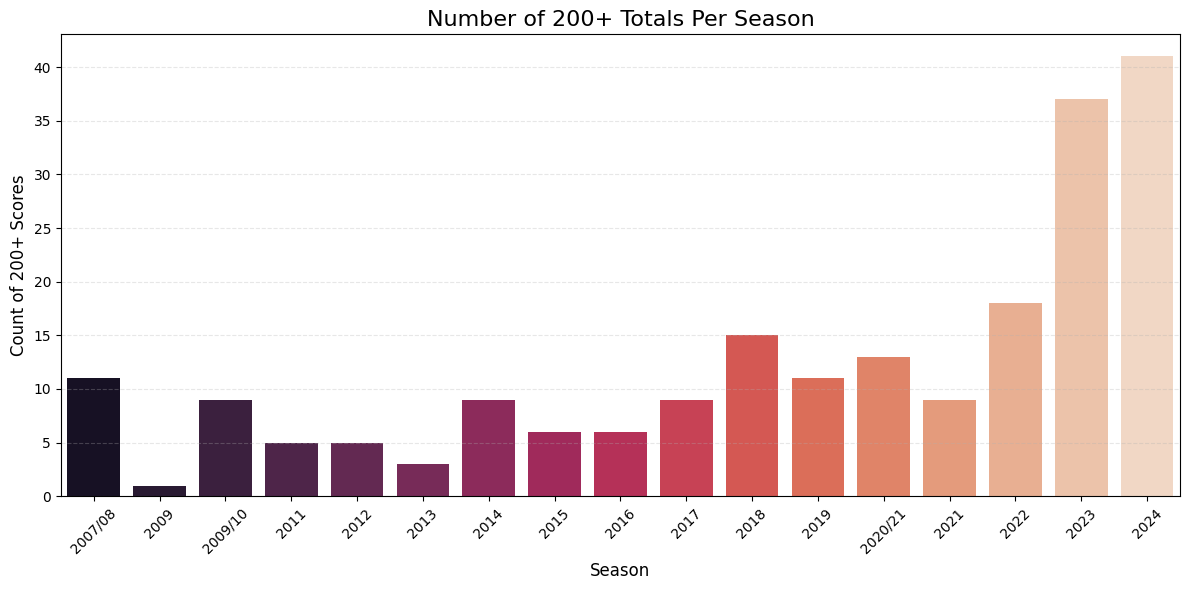

In [36]:
# Calculate team innings total for each match
team_innings_total = deliveries_df.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].sum().reset_index()

# Merge with matches data to get season information
team_innings_total_season = team_innings_total.merge(matches_df[['id', 'season']], left_on='match_id', right_on='id')

# Find innings with 200+ runs
high_scoring_innings = team_innings_total_season[team_innings_total_season['total_runs'] >= 200]

# Count 200+ totals per season
high_scores_per_season = high_scoring_innings.groupby('season').size().reset_index(name='count_200_plus')

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x='season', y='count_200_plus', data=high_scores_per_season, palette='rocket')
plt.title('Number of 200+ Totals Per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Count of 200+ Scores', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Key Takeaways
The number of 200+ totals per season has seen a significant rise, particularly from 2022 onwards, indicating a shift toward high-scoring games. The sharp increase in 2023 and 2024 suggests that teams are consistently breaching the 200-run mark more frequently than ever before.

In the earlier seasons (2008-2015), 200+ scores were relatively rare, likely due to balanced bowling attacks, slower pitches, and a more conservative batting approach. However, as the format evolved, teams adapted a more aggressive strategy, leading to a gradual increase in high totals.

The recent surge in 200+ scores can be attributed to factors like improved batting depth, better power-hitting techniques, favorable pitch conditions, and strategic rule changes such as impact players and fielding restrictions. These factors collectively highlight the growing dominance of batsmen in T20 cricket.

### 3. Find the average score of each team per season


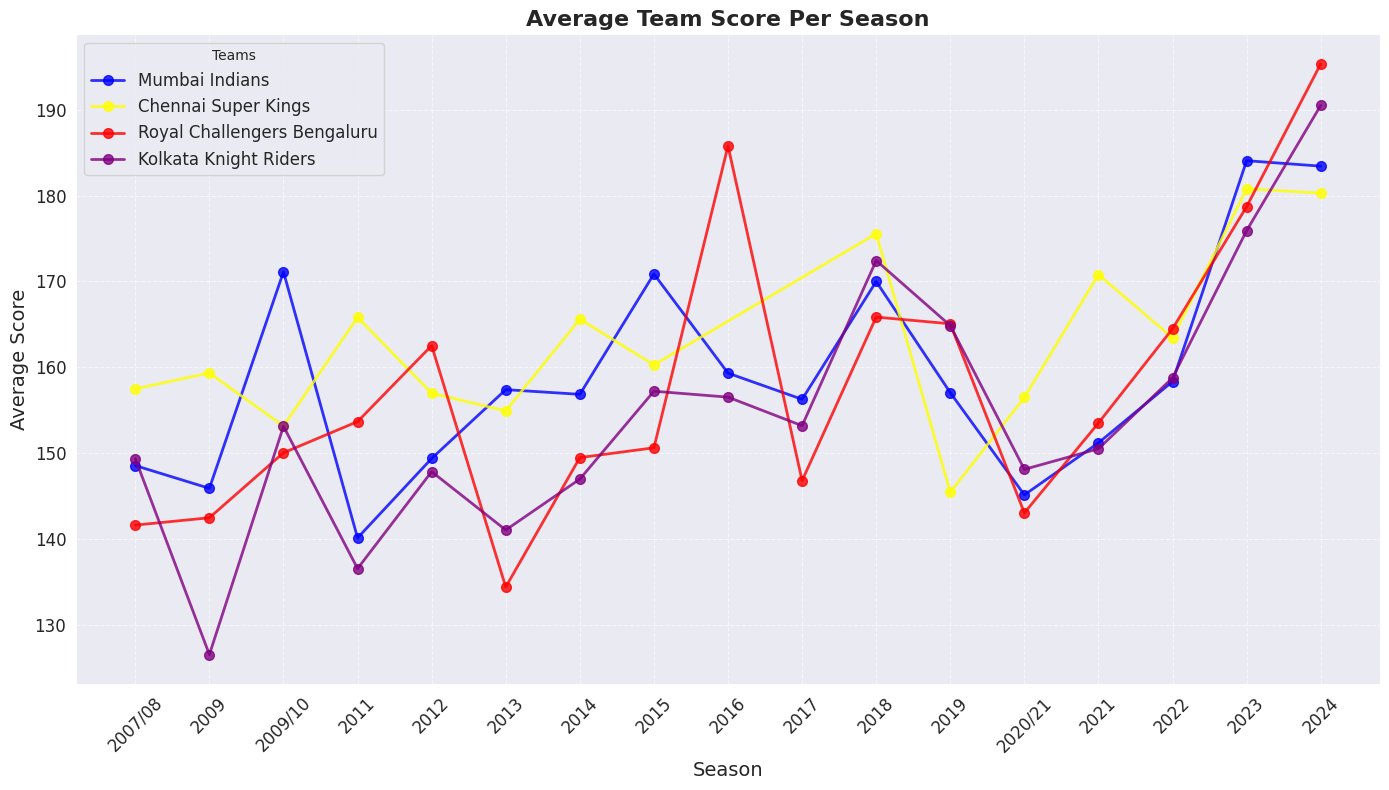

In [41]:
# Calculate team innings total for each match
team_innings_total = deliveries_df.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].sum().reset_index()

# Merge with matches data to get season information
team_season_scores = team_innings_total.merge(matches_df[['id', 'season']], left_on='match_id', right_on='id')

# Calculate average score for each team per season
avg_team_score_per_season = team_season_scores.groupby(['season', 'batting_team'])['total_runs'].mean().reset_index()

# Define figure size
plt.figure(figsize=(14, 8))

# Define team colors
team_colors = {
    'Mumbai Indians': 'blue',
    'Chennai Super Kings': 'yellow',
    'Royal Challengers Bengaluru': 'red',
    'Kolkata Knight Riders': 'purple'
}

# Plot data for each team
for team in team_colors.keys():
    team_data = avg_team_score_per_season[avg_team_score_per_season['batting_team'] == team]
    plt.plot(team_data['season'], team_data['total_runs'],
             marker='o', linewidth=2, markersize=7,
             color=team_colors[team], label=team, alpha=0.8)

# Titles and labels
plt.title('Average Team Score Per Season', fontsize=16, fontweight='bold')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Score', fontsize=14)

# Add grid, legend, and rotate x-axis labels
plt.legend(title="Teams", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Key Takeaways
All four teams (MI, CSK, RCB, KKR) show an upward trend in average scores over the seasons, indicating that batting performances and scoring rates have improved over time.

Royal Challengers Bengaluru (RCB) (red line) has seen sharp peaks and drops, suggesting inconsistency in batting performances. They have some of the highest seasonal peaks but also low dips, possibly due to reliance on star players.

Mumbai Indians (blue) and Chennai Super Kings (yellow) maintain relatively stable and competitive scoring trends, showing their consistent batting strength across seasons. KKR (purple) follows a similar pattern but with occasional dips.

### 4. Analyze runs of Orange Cap Holders per season


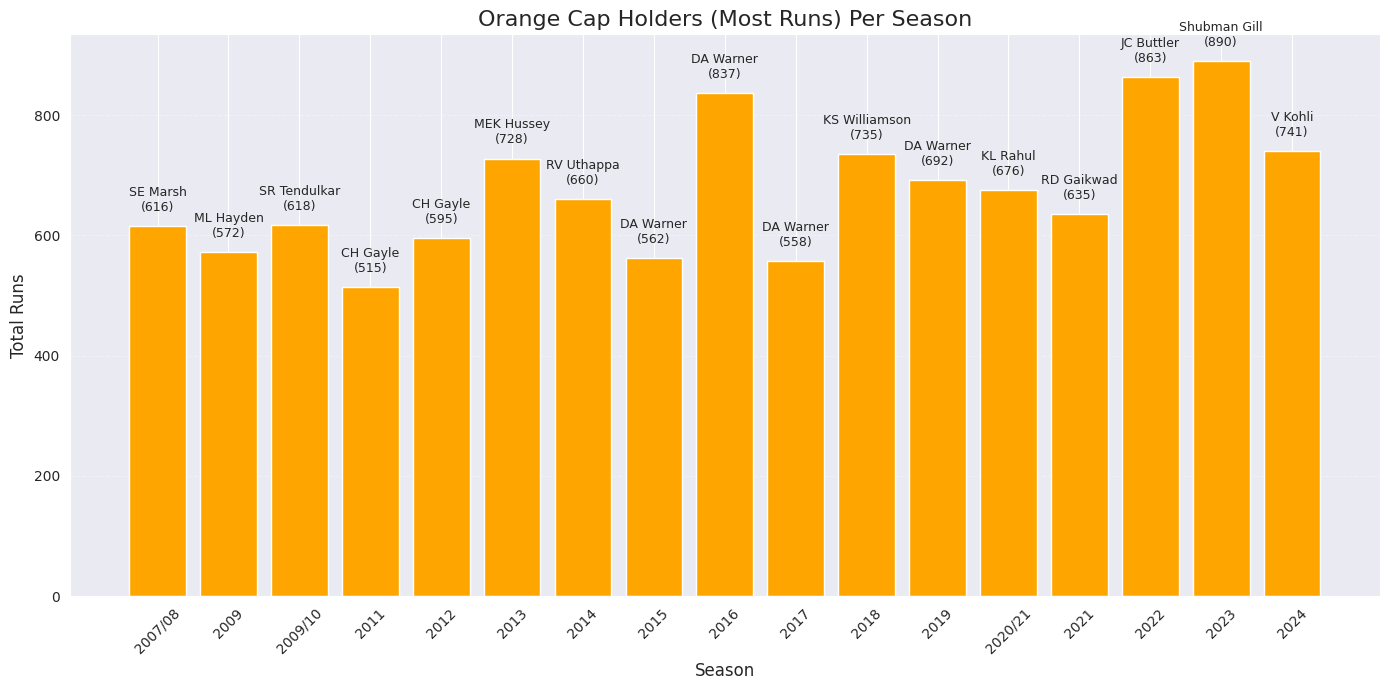

In [42]:
# Calculate total runs for each batsman per season
batsman_season_runs = deliveries_df.merge(matches_df[['id', 'season']], left_on='match_id', right_on='id')
batsman_season_runs = batsman_season_runs.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()

# Find the Orange Cap holder for each season (top run-scorer)
orange_cap_holders = batsman_season_runs.loc[batsman_season_runs.groupby('season')['batsman_runs'].idxmax()]
orange_cap_holders = orange_cap_holders.rename(columns={'batsman_runs': 'total_runs'})

# Visualize
plt.figure(figsize=(14, 7))
bars = plt.bar(orange_cap_holders['season'], orange_cap_holders['total_runs'], color='orange')

# Add player names on top of bars
for bar, player, runs in zip(bars, orange_cap_holders['batter'], orange_cap_holders['total_runs']):
    plt.text(bar.get_x() + bar.get_width()/2, runs + 20,
             f"{player}\n({runs})",
             ha='center', va='bottom', rotation=0, fontsize=9)

plt.title('Orange Cap Holders (Most Runs) Per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Runs', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 4. Track wickets of Purple Cap Holders per season


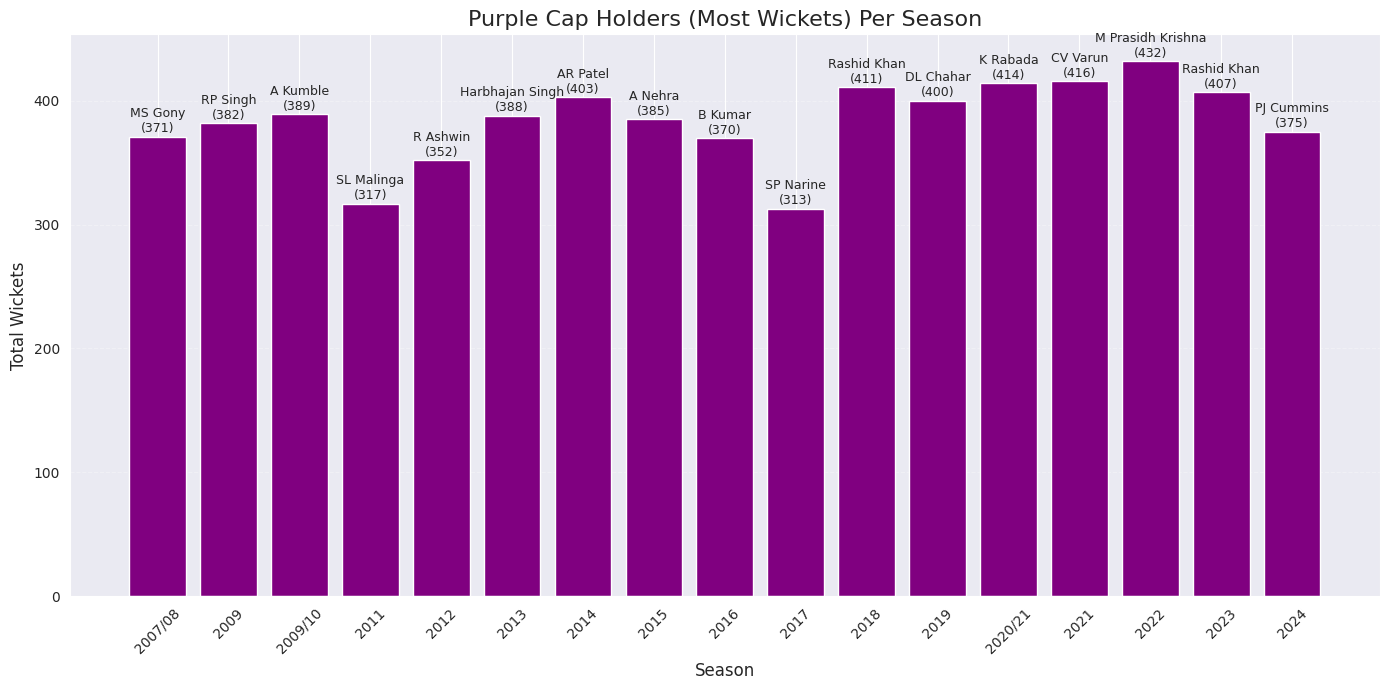

In [43]:
# Calculate total wickets for each bowler per season
# Consider only player_dismissed events to count wickets
wicket_data = deliveries_df[deliveries_df['player_dismissed'].notna()]
bowler_season_wickets = wicket_data.merge(matches_df[['id', 'season']], left_on='match_id', right_on='id')
bowler_season_wickets = bowler_season_wickets.groupby(['season', 'bowler']).size().reset_index(name='wickets')

# Find the Purple Cap holder for each season (top wicket-taker)
purple_cap_holders = bowler_season_wickets.loc[bowler_season_wickets.groupby('season')['wickets'].idxmax()]

# Visualize
plt.figure(figsize=(14, 7))
bars = plt.bar(purple_cap_holders['season'], purple_cap_holders['wickets'], color='purple')

# Add player names on top of bars
for bar, player, wickets in zip(bars, purple_cap_holders['bowler'], purple_cap_holders['wickets']):
    plt.text(bar.get_x() + bar.get_width()/2, wickets + 1,
             f"{player}\n({wickets})",
             ha='center', va='bottom', rotation=0, fontsize=9)

plt.title('Purple Cap Holders (Most Wickets) Per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Wickets', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 6. Find top 10 bowlers per season


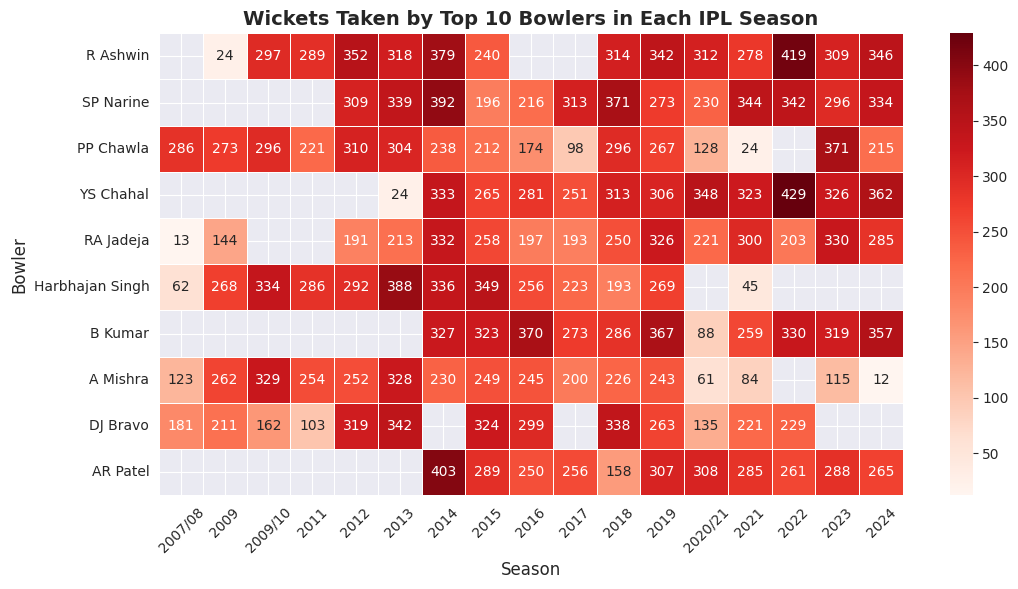

In [45]:
pivot_df = bowler_season_wickets.pivot(index='bowler', columns='season', values='wickets')

# Select top 10 overall wicket-takers
top_bowlers = pivot_df.sum(axis=1).nlargest(10).index
pivot_df = pivot_df.loc[top_bowlers]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap='Reds', annot=True, linewidths=0.5, fmt=".0f")

plt.title('Wickets Taken by Top 10 Bowlers in Each IPL Season', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Bowler', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Key Takeaways
YS Chahal and AR Patel were the most dominant bowlers, with peak seasons of 429 and 403 wickets, respectively, indicating sustained excellence.

Harbhajan Singh, Amit Mishra, and Piyush Chawla had strong early seasons but declined over time, while Ravindra Jadeja improved steadily.

Some bowlers had standout peak seasons (Ashwin - 419 wickets, Narine - 392 wickets) but weren't consistently at the top every year.

## Feature Extracting
Now let us move ahead and start training the model and extracting features.

In [47]:
# Define input (X) and target (y)
X = matches_df.drop(columns=['winner'])  # Drop the target variable
y = matches_df['winner']  # Target column
le = LabelEncoder()
y = le.fit_transform(y)

# Convert categorical variables
X = pd.get_dummies(X)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

# Feature Clustering Using K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
X['Cluster'] = kmeans.fit_predict(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")


Gradient Boosting Accuracy: 0.8259
XGBoost Accuracy: 0.8159


So, what we did here was build an ensemble model using Gradient Boosting and XGBoost as our base classifiers. Instead of relying on just one model, we combined them using a soft voting ensemble, which means it takes the probability predictions from both models and averages them to make a final decision. After training the ensemble on our dataset, we tested it on unseen data and calculated its accuracy. To get a clearer picture of how well it performed, we also plotted a confusion matrix, which helps visualize where the model is making correct and incorrect predictions. Overall, this approach leverages the strengths of both models to improve classification performance!

Voting Ensemble Accuracy: 0.8507


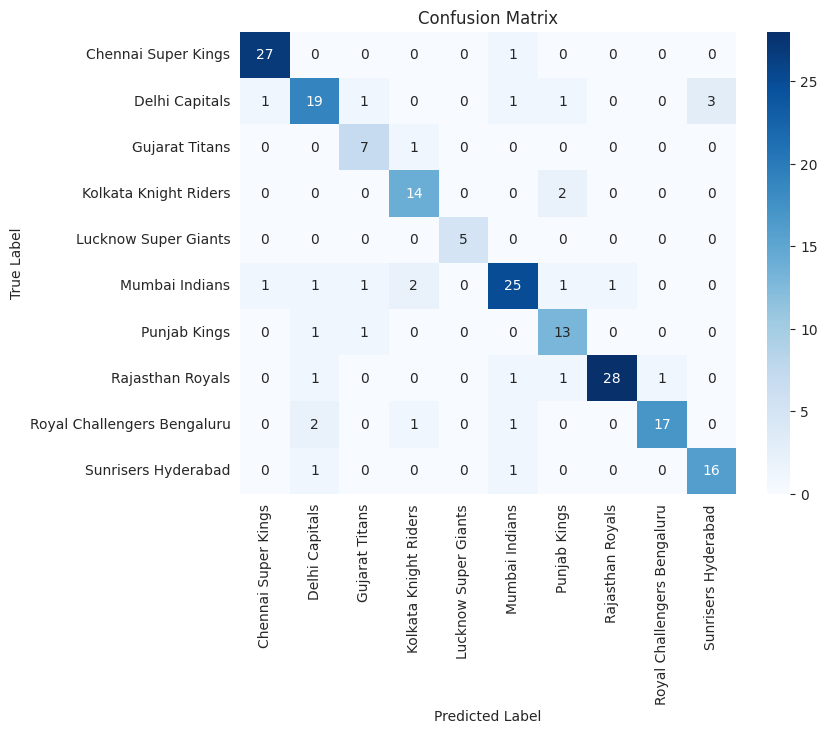

In [49]:
from sklearn.metrics import confusion_matrix

# Define base models
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Voting ensemble
voting_ensemble = VotingClassifier(estimators=[('Gradient Boosting', gb), ('XGBoost', xgb)], voting='soft')

# Train and evaluate ensemble model
voting_ensemble.fit(X_train, y_train)
y_pred = voting_ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Voting Ensemble Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

We have achieved an accuracy of 85% in training the model using the ensemble model.

Now we are trying to deploy the model and get predictions.

In [50]:
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Rising Pune Supergiant': 'Rising Pune Supergiants',
    'Kings XI Punjab': 'Punjab Kings',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Gujarat Lions': 'Gujarat Titans',
}

matches_df = matches_df[['team1', 'team2', 'winner']]

# Apply the mapping to the matches dataset
matches_df['team1'] = matches_df['team1'].replace(team_name_mapping)
matches_df['team2'] = matches_df['team2'].replace(team_name_mapping)
matches_df['winner'] = matches_df['winner'].replace(team_name_mapping)
print("Unique team names in matches dataset (team1):")
print(matches_df['team1'].unique())
print("\nUnique team names in matches dataset (team2):")
print(matches_df['team2'].unique())

Unique team names in matches dataset (team1):
['Royal Challengers Bengaluru' 'Punjab Kings' 'Delhi Capitals'
 'Mumbai Indians' 'Kolkata Knight Riders' 'Rajasthan Royals'
 'Sunrisers Hyderabad' 'Chennai Super Kings' 'Gujarat Titans'
 'Lucknow Super Giants']

Unique team names in matches dataset (team2):
['Kolkata Knight Riders' 'Chennai Super Kings' 'Rajasthan Royals'
 'Royal Challengers Bengaluru' 'Sunrisers Hyderabad' 'Punjab Kings'
 'Delhi Capitals' 'Mumbai Indians' 'Gujarat Titans' 'Lucknow Super Giants']


In [51]:
team_name_mapping_num = {
    'Royal Challengers Bengaluru': 0,
    'Punjab Kings': 1,
    'Delhi Capitals': 2,
    'Mumbai Indians': 3,
    'Kolkata Knight Riders': 4,
    'Rajasthan Royals': 5,
    'Sunrisers Hyderabad': 6,
    'Chennai Super Kings': 7,
    'Kochi Tuskers Kerala': 8,
    'Pune Warriors': 9,
    'Gujarat Titans': 10,
    'Rising Pune Supergiants': 11,
    'Lucknow Super Giants': 12,
}

matches_df['team1'] = matches_df['team1'].replace(team_name_mapping_num)
matches_df['team2'] = matches_df['team2'].replace(team_name_mapping_num)
matches_df['winner'] = matches_df['winner'].replace(team_name_mapping_num)
matches_df.dropna(how='any', inplace=True)

In [52]:
X = matches_df.drop('winner', axis = 1)
y = matches_df['winner']

In [71]:
valid_classes = np.unique(y_train)  # Get valid labels from training set

y_test = np.array([label if label in valid_classes else -1 for label in y_test])

if -1 in y_test:
    print("Warning: Some labels in y_test were not found in y_train!")


In [72]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Accuracy: 0.5418227215980026


Applying the best parameters of Gradient Boosting in the ensemble model. We get the best accuracy of 51.74%

In [76]:
models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42, max_depth=3),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")

Gradient Boosting Accuracy: 0.5174
XGBoost Accuracy: 0.4925
KNN Accuracy: 0.4925
Random Forest Accuracy: 0.4876


In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Voting Ensemble Accuracy: 0.4925


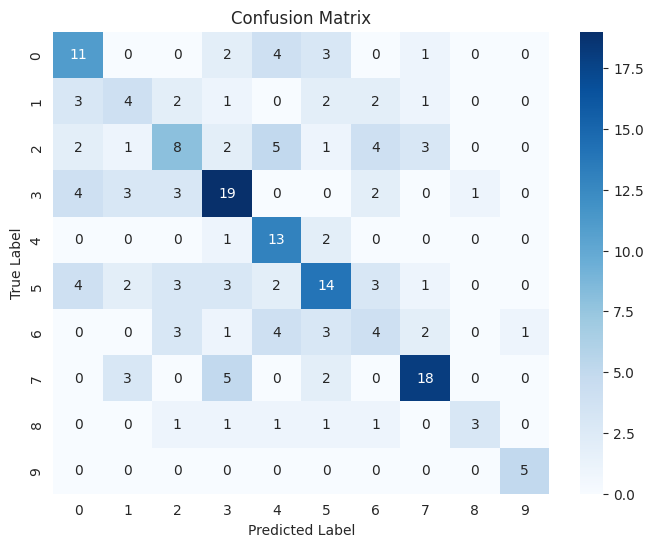

In [77]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Voting ensemble
voting_ensemble = VotingClassifier(estimators=[('Gradient Boosting', gb), ('XGBoost', xgb)], voting='soft')

# Train and evaluate ensemble model
voting_ensemble.fit(X_train, y_train)
y_pred = voting_ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Voting Ensemble Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Finally, we are getting an accuracy of 49.25 which is considerably lower than our training data accuracy. It might be due to noise and overfitting of the data.

In [78]:
joblib.dump(voting_ensemble, '/content/model.pkl')


['/content/model.pkl']

Let's now predict the matches as per the fixtures of IPL 2025.

In [81]:
model = joblib.load('/content/model.pkl')

test_data_path = '/content/testdata.csv'
test_data = pd.read_csv(test_data_path)

test_data = test_data[['team1', 'team2']]
team_name_mapping_num = {
    'Royal Challengers Bengaluru': 0,
    'Punjab Kings': 1,
    'Delhi Capitals': 2,
    'Mumbai Indians': 3,
    'Kolkata Knight Riders': 4,
    'Rajasthan Royals': 5,
    'Sunrisers Hyderabad': 6,
    'Chennai Super Kings': 7,
    'Kochi Tuskers Kerala': 8,
    'Pune Warriors': 9,
    'Gujarat Titans': 10,
    'Rising Pune Supergiants': 11,
    'Lucknow Super Giants': 12,
}

test_data['team1'] = test_data['team1'].replace(team_name_mapping_num)
test_data['team2'] = test_data['team2'].replace(team_name_mapping_num)
test_data.dropna(how='any', inplace=True)

In [82]:
test_data['team1'] = test_data['team1'].astype(int)
test_data['team2'] = test_data['team2'].astype(int)
winner_pred = model.predict(test_data)

In [83]:
# Create an inverse mapping dictionary
inverse_team_mapping = {value: key for key, value in team_name_mapping_num.items()}

# Map predicted IDs to team names
predicted_team_names = [inverse_team_mapping[team_id] for team_id in winner_pred]
test_data['team1'] = [inverse_team_mapping[team_id] for team_id in test_data['team1']]
test_data['team2'] = [inverse_team_mapping[team_id] for team_id in test_data['team2']]

# Print the predicted team names
print(predicted_team_names)

['Kolkata Knight Riders', 'Rajasthan Royals', 'Mumbai Indians', 'Delhi Capitals', 'Punjab Kings', 'Rajasthan Royals', 'Pune Warriors', 'Chennai Super Kings', 'Kochi Tuskers Kerala', 'Delhi Capitals', 'Rajasthan Royals', 'Mumbai Indians', 'Pune Warriors', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Pune Warriors', 'Chennai Super Kings', 'Rajasthan Royals', 'Kolkata Knight Riders', 'Sunrisers Hyderabad', 'Royal Challengers Bengaluru', 'Punjab Kings', 'Rajasthan Royals', 'Royal Challengers Bengaluru', 'Chennai Super Kings', 'Kochi Tuskers Kerala', 'Sunrisers Hyderabad', 'Royal Challengers Bengaluru', 'Delhi Capitals', 'Pune Warriors', 'Kolkata Knight Riders', 'Delhi Capitals', 'Mumbai Indians', 'Royal Challengers Bengaluru', 'Delhi Capitals', 'Rajasthan Royals', 'Punjab Kings', 'Mumbai Indians', 'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad', 'Rajasthan Royals', 'Chennai Super Kings', 'Kolkata Knight Riders', 'Mumbai Indians', 'Royal Challengers Bengaluru', 'Kochi Tu

We are saving the predictions in a csv file.

In [99]:
# Create a DataFrame with team names and predicted winner
results_df = pd.DataFrame({
    'team1': test_data['team1'],
    'team2': test_data['team2'],
    'winner': predicted_team_names
})
results_df.to_csv('/content/predictions.csv', index=False)

In [100]:
data = pd.read_csv('/content/predictions.csv')
print(data.head())

                   team1                        team2  \
0  Kolkata Knight Riders  Royal Challengers Bengaluru   
1    Sunrisers Hyderabad             Rajasthan Royals   
2    Chennai Super Kings               Mumbai Indians   
3         Delhi Capitals         Lucknow Super Giants   
4         Gujarat Titans                 Punjab Kings   

                        winner  
0  Royal Challengers Bengaluru  
1             Rajasthan Royals  
2               Mumbai Indians  
3               Delhi Capitals  
4                 Punjab Kings  


So finally, we have gotten the predictions as per the fixtures of IPL 2025. As per the first match, our model correctly predicts the win of Royal Challengers Bengaluru. The rest of the predictions are yet to be tested.

# Problem Statement 2

Let us start by importing the necessary libraries. We will be using these libraries for Natural Language Processing and Data Analysis.

In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from summa.summarizer import summarize
from datasets import load_dataset
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration

## Dataset Preparation for Summarization

We will be working with three datasets for research text summarization.

### 1. PubMed Summarization Dataset  
The PubMed dataset consists of biomedical research papers sourced from PubMed, including their abstracts and summaries. It is commonly used for tasks requiring domain-specific text processing in the medical field.

### 2. arXiv Summarization Dataset  
The arXiv dataset contains research papers from arXiv along with human-written summaries. It is a valuable resource for training models to generate concise summaries of complex scientific articles.  

### 3. CompScholar Dataset
This contains research articles and their summaries. This dataset will help enhance our model's ability to generate high-quality summaries across various academic domains.

We will load the datasets and examine the available data splits. Here, train, validation and test are present.

In [ ]:
pubmed=load_dataset("ccdv/pubmed-summarization")
print(pubmed.keys())

arxiv=load_dataset("ccdv/arxiv-summarization")
print(arxiv.keys())

train-00001-of-00005.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/207M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

dict_keys(['train', 'validation', 'test'])


README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

dict_keys(['train', 'validation', 'test'])


In [ ]:
comp_scholar=pd.read_csv("/content/Brain Dead CompScholar Dataset.csv")

print(comp_scholar.head())

   Paper Id                                        Paper Title  \
0         1  Multi-document Summarization via Deep Learning...   
1         2  NLP based Machine Learning Approaches for Text...   
2         3  Abstractive text summarization using LSTM-CNN ...   
3         4  DEXPERTS: Decoding-Time Controlled Text Genera...   
4         5     A Survey of Knowledge-enhanced Text Generation   

                                           Key Words  \
0  Multi-document summarization (MDS), Deep learn...   
1  Text summarization, Abstractive and extractive...   
2  Text mining . Abstractive text summarization ....   
3  Natural language generation, Controlled text g...   
4  text-to-text generation, natural language proc...   

                                            Abstract  \
0  Multi-document summarization (MDS) is an effec...   
1  Due to the plethora of data available today, t...   
2   Abstractive Text Summarization (ATS), which i...   
3  Despite recent advances in natural lang

## Data Cleaning

We will now begin with Data Cleaning.
The CompScholar Dataset is cleaned and renaming the 'Document' and 'Summary' to 'text' and 'summary' for generality.

The ArXiv Dataset is cleaned and each research paper's title and abstract are concatenated to form the 'text', while the abstract itself serves as the 'summary'. The processed data is stored in a Pandas DataFrame.

The PubMed Dataset is cleaned and we are checking is each entry is a dictionary before processing. Only records with both 'text' and 'summary' are included in the cleaned DataFrame.  

Missing values are removed for each dataset.

In [ ]:
comp_scholar["text"] = comp_scholar["Document"]
comp_scholar["summary"] = comp_scholar["Summary"]

comp_scholar = comp_scholar[["text", "summary"]]
comp_scholar.dropna(inplace=True)

<ipython-input-8-5ce891eda086>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_scholar.dropna(inplace=True)


In [ ]:
arxiv_cleaned = []

for paper in arxiv['train']:
    text = paper.get("title", "") + " " + paper.get("abstract", "")
    summary = paper.get("abstract", "")
    arxiv_cleaned.append({"text": text, "summary": summary})

arxiv_df = pd.DataFrame(arxiv_cleaned)
arxiv_df.dropna(inplace=True)

print(arxiv_df.head())

                                                text  \
0   additive models play an important role in sem...   
1   we have studied the leptonic decay @xmath0 , ...   
2   in 84 , 258 ( 2000 ) , mateos conjectured tha...   
3   the effect of a random phase diffuser on fluc...   
4   with a special intention of clarifying the un...   

                                             summary  
0  additive models play an important role in semi...  
1  we have studied the leptonic decay @xmath0 , v...  
2  in 84 , 258 ( 2000 ) , mateos conjectured that...  
3  the effect of a random phase diffuser on fluct...  
4  with a special intention of clarifying the und...  


In [ ]:
train_data = list(pubmed["train"])

pubmed_cleaned = []
for paper in train_data:
    if isinstance(paper, dict):
        article = paper.get("article", [])
        abstract = paper.get("abstract", [])

        if isinstance(article, list):
            article = " ".join(article).strip()
        if isinstance(abstract, list):
            abstract = " ".join(abstract).strip()

        if article and abstract:
            pubmed_cleaned.append({"text": article, "summary": abstract})

pubmed_df = pd.DataFrame(pubmed_cleaned)

print(pubmed_df.head())
print(pubmed_df.shape)

                                                text  \
0  a recent systematic analysis showed that in 20...   
1  it occurs in more than 50% of patients and may...   
2  tardive dystonia ( td ) , a rarer side effect ...   
3  lepidoptera include agricultural pests that , ...   
4  syncope is caused by transient diffuse cerebra...   

                                             summary  
0  background : the present study was carried out...  
1  backgroundanemia in patients with cancer who a...  
2  tardive dystonia ( td ) is a serious side effe...  
3  many lepidopteran insects are agricultural pes...  
4  we present an unusual case of recurrent cough ...  
(117232, 2)


Now that we’ve cleaned up the datasets, let’s do a quick check before moving forward.  

First, we print the number of records in each dataset. Then we check a few random samples from each dataset to look at how text and summaries are structured. Lastly, we are double checking if any fields are missing.

In [ ]:
print("PubMed Dataset Shape:", pubmed_df.shape)
print("ArXiv Dataset Shape:", arxiv_df.shape)
print("CompScholar Dataset Shape:", comp_scholar.shape)

print("PubMed Sample:\n", pubmed_df.sample(3))
print("ArXiv Sample:\n", arxiv_df.sample(3))
print("CompScholar Sample:\n", comp_scholar.sample(3))

print("Missing Values in PubMed:\n", pubmed_df.isnull().sum())
print("Missing Values in ArXiv:\n", arxiv_df.isnull().sum())
print("Missing Values in CompScholar:\n", comp_scholar.isnull().sum())

PubMed Dataset Shape: (117232, 2)
ArXiv Dataset Shape: (203037, 2)
CompScholar Dataset Shape: (371, 2)
PubMed Sample:
                                                      text  \
21762   multicentric reticulohistiocytosis ( mrh ) is ...   
18910   we report a case of a patient who presented wi...   
114717  all aspects of the study detailed herein were ...   

                                                  summary  
21762   a 58-year - old lady presented with polyarthri...  
18910   there are multiple causes of lung abscess , bu...  
114717  abstractthe purpose of this study was to compa...  
ArXiv Sample:
                                                      text  \
52802    we present a theoretical calibration of the r...   
199910   in this paper i describe a new optimal krylov...   
46783    we investigate the competition between the sp...   

                                                  summary  
52802   we present a theoretical calibration of the rr...  
199910  in this 

## Data Preprocessing
Let us first take a look at the length of articles in each dataset. This will help choosing an efficient model. It will also help in spotting any outliers (super long or super short texts).

We see some interesting insights.
PubMed: Most articles are relatively short, but there are a few extreme outliers with very long text lengths (some even exceeding 100,000 words!).

ArXiv: The majority of articles are much shorter than PubMed, typically staying below 5,000 words. This dataset seems to have a more uniform distribution without massive outliers.

CompScholar: Compared to the other two, this dataset has a more balanced distribution of article lengths, with most texts ranging between 200–1,500 words. This is great for summarization since it won’t require much preprocessing.

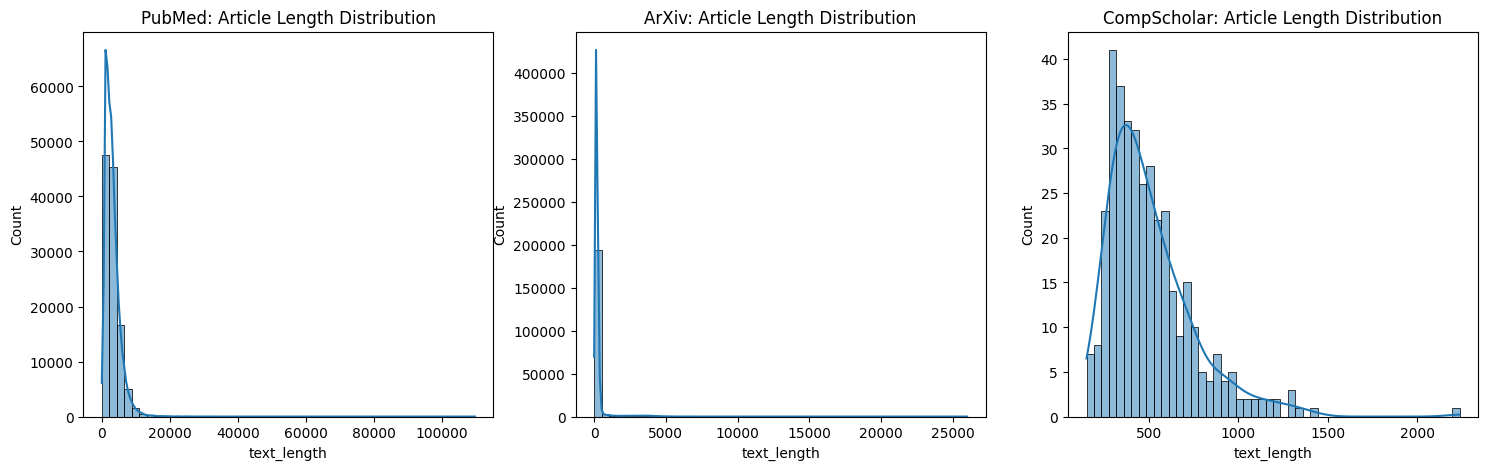

In [ ]:
pubmed_df["text_length"] = pubmed_df["text"].apply(lambda x: len(x.split()))
pubmed_df["summary_length"] = pubmed_df["summary"].apply(lambda x: len(x.split()))

arxiv_df["text_length"] = arxiv_df["text"].apply(lambda x: len(x.split()))
arxiv_df["summary_length"] = arxiv_df["summary"].apply(lambda x: len(x.split()))

comp_scholar["text_length"] = comp_scholar["text"].apply(lambda x: len(x.split()))
comp_scholar["summary_length"] = comp_scholar["summary"].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(pubmed_df["text_length"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("PubMed: Article Length Distribution")

sns.histplot(arxiv_df["text_length"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("ArXiv: Article Length Distribution")

sns.histplot(comp_scholar["text_length"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("CompScholar: Article Length Distribution")

plt.show()

We analyzed the most common words in each dataset (after removing stopwords) to get a sense of dominant themes:  

- PubMed: Has frequent words related to medical research, diseases, and treatments.  
- arXiv: More technical and mathematical terms dominate due to the research-heavy nature of the dataset.  
- CompScholar: Features academic and scholarly terms used in interdisciplinary research papers.  

The word cloud visualization for PubMed articles gives a clear picture of high-frequency words. We see terms like *patients, treatment, study*, it confirms that the dataset is highly medical-focused.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Top words in PubMed: [('patients', 53411), ('study', 38237), ('also', 25077), ('using', 24886), ('cells', 24368), ('group', 22519), ('may', 22150), ('used', 21989), ('et', 21417), ('treatment', 19838), ('al', 19826), ('p', 19519), ('one', 19289), ('data', 19173), ('two', 18764), ('studies', 18599), ('figure', 17475), ('patient', 16733), ('time', 16563), ('cell', 16341)]
Top words in ArXiv: [('xcite', 4639), ('model', 3335), ('two', 3290), ('field', 2771), ('energy', 2619), ('one', 2485), ('also', 2238), ('results', 2138), ('quantum', 2091), ('state', 2059), ('time', 1955), ('using', 1924), ('mass', 1903), ('system', 1853), ('phase', 1807), ('show', 1786), ('data', 1774), ('magnetic', 1741), ('spin', 1703), ('order', 1672)]
Top words in CompScholar: [('data', 991), ('learning', 882), ('model', 777), ('analysis', 748), ('recognition', 709), ('sentiment', 603), ('using', 596), ('social', 551), ('deep', 550), ('facial', 507), ('proposed', 499), ('results', 479), ('based', 473), ('research'

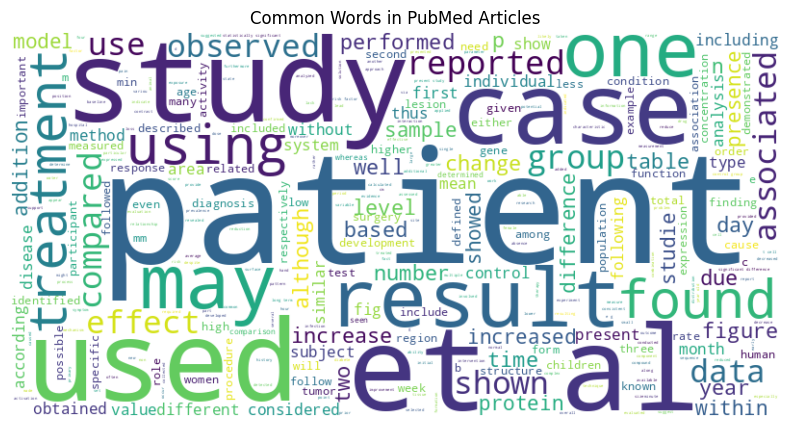

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

def get_top_words(texts, num_words=20):
    words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(words).most_common(num_words)

sample_size_pubmed = min(5000, len(pubmed_df["text"]))
sample_size_arxiv = min(5000, len(arxiv_df["text"]))
sample_size_comp = min(5000, len(comp_scholar["text"]))

sample_texts_pubmed = pubmed_df["text"].sample(n=sample_size_pubmed, random_state=42)
sample_texts_arxiv = arxiv_df["text"].sample(n=sample_size_arxiv, random_state=42)
sample_texts_comp = comp_scholar["text"].sample(n=sample_size_comp, random_state=42)

print("Top words in PubMed:", get_top_words(sample_texts_pubmed))
print("Top words in ArXiv:", get_top_words(sample_texts_arxiv))
print("Top words in CompScholar:", get_top_words(sample_texts_comp))

wordcloud = WordCloud(width=800, height=400, max_words=300, background_color="white").generate(" ".join(sample_texts_pubmed))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in PubMed Articles")
plt.show()

To understand the variability in summaries, we extracted the shortest and longest summaries for each dataset.  

PubMed’s shortest summary contains only 42 words, offering minimal context. This could indicate an incomplete abstract or a very concise statement. The longest summary has 391 words, suggesting a more detailed abstract that includes background, methodology, and results.

ArXiv has an issue where the shortest summary is completely empty. This means the dataset has missing or null summaries that need to be handled before training. The longest summary has 26,006 words, which is unusually long and could indicate that some full papers are mistakenly classified as summaries.  

CompScholar’s shortest summary is 241 words, which is still relatively detailed compared to PubMed’s shortest summary. This suggests that even the shortest summaries in this dataset provide substantial information. The dataset seems more balanced in terms of summary length.  

ArXiv requires special handling for missing summaries and extremely long ones. PubMed has significant variation in summary lengths, meaning normalization techniques might be necessary. CompScholar appears more consistent, making it easier to process.  


In [ ]:
print("Shortest Summary PubMed:\n", pubmed_df.loc[pubmed_df["summary_length"].idxmin()])
print("Longest Summary PubMed:\n", pubmed_df.loc[pubmed_df["summary_length"].idxmax()])

print("Shortest Summary Arxiv:\n", arxiv_df.loc[arxiv_df["summary_length"].idxmin()])
print("Longest Summary Arxiv:\n", arxiv_df.loc[arxiv_df["summary_length"].idxmax()])

print("Shortest Summary CompScholar:\n", comp_scholar.loc[comp_scholar["summary_length"].idxmin()])
print("Longest Summary CompScholar:\n", comp_scholar.loc[comp_scholar["summary_length"].idxmax()])

Shortest Summary PubMed:
 text              morphological techniques and terminologies fol...
summary           paragalboa acuta \n gen . & \n sp . n. is desc...
dataset                                                      PubMed
text_length                                                    2017
summary_length                                                   42
Name: 77537, dtype: object
Longest Summary PubMed:
 text              severe trauma and major surgery frequently res...
summary           background and aims : the aim of this study is...
dataset                                                      PubMed
text_length                                                    2853
summary_length                                                  391
Name: 116483, dtype: object
Shortest Summary Arxiv:
 text                   
summary                
dataset           arXiv
text_length           0
summary_length        0
Name: 58166, dtype: object
Longest Summary Arxiv:
 text              

In [ ]:
print(arxiv_df["summary"].isna().sum())
print((arxiv_df["summary"] == "").sum())
arxiv_df = arxiv_df[arxiv_df["summary"].notna() & (arxiv_df["summary"] != "")]

0
3


We will now compute the average cosine similarity between texts and their summaries for each dataset.  

In PubMed, the similarity score is 0.5920. This suggests that the summaries retain some key information but are not entirely extractive. The summaries might be paraphrased or shortened significantly.  

For ArXiv, we see a perfect similarity score of 1.0000. This indicates that the summaries are exact copies of the original text in our sampled dataset. This seems suspicious and we should investigate whether this is due to duplicate entries or incorrectly processed data.  

In CompScholar, the similarity score is 0.6897. This score is higher than PubMed but lower than ArXiv, indicating that the summaries are more closely aligned with the original text while still maintaining some level of abstraction.  

In [ ]:
def batch_cosine_similarity(X, Y, batch_size=1000):
    similarities = []
    for i in range(0, X.shape[0], batch_size):
        batch_sim = np.diag(cosine_similarity(X[i:i+batch_size], Y[i:i+batch_size]))
        similarities.extend(batch_sim)
    return np.array(similarities)

def compute_similarity(df, name, max_features=2000, batch_size=1000):
    if df.empty or "text" not in df or "summary" not in df:
        print(f"{name} dataset is empty or missing required columns.")
        return None

    df_sample = df.sample(n=min(5000, len(df)), random_state=42)

    vectorizer = TfidfVectorizer(max_features=max_features, stop_words="english")
    X = vectorizer.fit_transform(df_sample["text"])
    Y = vectorizer.transform(df_sample["summary"])

    similarities = batch_cosine_similarity(X, Y, batch_size=batch_size)
    df_sample["text_summary_similarity"] = similarities

    avg_sim = np.mean(similarities)
    print(f"Average Text-Summary Similarity in {name}: {avg_sim:.4f}")
    return df_sample

pubmed_df = compute_similarity(pubmed_df, "PubMed")
arxiv_df = compute_similarity(arxiv_df, "ArXiv")
comp_scholar = compute_similarity(comp_scholar, "CompScholar")

Average Text-Summary Similarity in PubMed: 0.5920
Average Text-Summary Similarity in ArXiv: 1.0000
Average Text-Summary Similarity in CompScholar: 0.6902


We see that the exact replica of text is in the summary. We can use other models to generate summary for this.

In [ ]:
print(arxiv_df[["text", "summary"]].sample(5, random_state=42))

                                                     text  \
12518    we study the spindown of isolated neutron sta...   
193435   we analyze whether one can construct a spectr...   
78918    we propose an effective lattice hamiltonian f...   
166788   we investigate the fermi polaron problem in a...   
167392   we present the results of a deep search for t...   

                                                  summary  
12518   we study the spindown of isolated neutron star...  
193435  we analyze whether one can construct a spectra...  
78918   we propose an effective lattice hamiltonian fo...  
166788  we investigate the fermi polaron problem in a ...  
167392  we present the results of a deep search for th...  


Now let's merge the three datasets into a single dataset for training while keeping track of their sources. For that, we are introducing a label 'dataset' in the DataFrame.

In [ ]:
comp_scholar["dataset"] = "CompScholar"

pubmed_df["dataset"] = "PubMed"

arxiv_df["dataset"] = "arXiv"

final_df = pd.concat([comp_scholar, arxiv_df, pubmed_df], ignore_index=True)
print(f"Total samples: {len(final_df)}")
final_df.head()

Total samples: 320640


,text,summary,text_length,summary_length,dataset
0,Multi-document Summarization via Deep Learning...,This article presents a systematic overview of...,319,72,CompScholar
1,NLP based Machine Learning Approaches for Text...,The article discusses the importance of text s...,385,87,CompScholar
2,Abstractive text summarization using LSTM-CNN ...,The article presents a new framework for abstr...,318,88,CompScholar
3,DEXPERTS: Decoding-Time Controlled Text Genera...,The paper proposes a method called DEXPERTS fo...,357,72,CompScholar
4,A Survey of Knowledge-enhanced Text Generation...,The paper discusses the challenges in text-to-...,362,68,CompScholar


To understand the relationship between the length of research articles and their corresponding summaries in the merged dataset, we created a scatter plot.


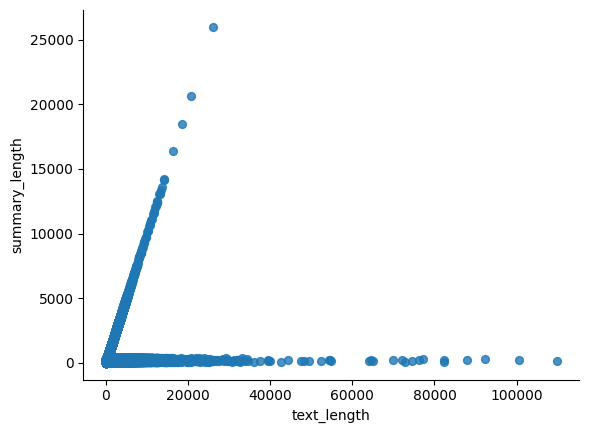

In [ ]:
final_df.plot(kind='scatter', x='text_length', y='summary_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
final_df

,text,summary,text_length,summary_length,text_summary_similarity,dataset
0,Sentiment Analysis for Social MediaSentiment A...,Sentiment analysis is the automated extraction...,258,125,0.756749,CompScholar
1,An overview of deep learning methods for multi...,The paper provides an overview of deep learnin...,866,145,0.174590,CompScholar
2,Childhood Interstitial Lung Disease: A Systema...,Childhood interstitial lung disease (chILD) is...,529,131,0.808547,CompScholar
3,"Polarity shift detection, elimination and ense...",The text discusses the issue of polarity shift...,346,103,0.870872,CompScholar
4,Prognostic role of blood KL-6 in rheumatoid ar...,This study aimed to investigate the prognostic...,485,108,0.711859,CompScholar
...,...,...,...,...,...,...
10366,twin pregnancies occur in approximately 1% of ...,purpose : to compare umbilical arterial gas pa...,2811,263,0.864631,PubMed
10367,the concept of probiotics was introduced in ea...,there has been an increased influx of probioti...,2167,168,0.529401,PubMed
10368,degenerative aortic valve stenosis ( as ) has ...,micrornas ( mirnas ) are a huge class of nonco...,2414,263,0.417520,PubMed
10369,unregulated oncogene expression during cancer ...,recent high - throughput - sequencing of the c...,3130,227,0.282549,PubMed


Now that we have merged multiple research datasets, we proceed with training our summarization model to surpass state-of-the-art (SOTA) models in research paper summarization.
Since research papers are long, we are using TextRank to extract key sentences. TextRank is an extractive summarization algorithm. It picks the most important sentences from a text and gives us a shorter, more informative version before we pass it to the model.
This reduces input length and speeds up abstractive summarization.
'extractive_summary()' extracts top 5 key sentences using TextRank.


In [ ]:
nltk.download('punkt_tab')
def extractive_summary(text, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

final_df["filtered_text"] = final_df["text"].apply(lambda x: extractive_summary(x, num_sentences=5))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Now, instead of passing full research papers into PEGASUS/BART, we pass a shorter, more focused version. This results in faster and efficient model.
Next we'll tokenize input text into numbers so that we can train the model. We have limited max sequence length to fit CPU processing.


First we tried PEGASUS, which is specifically designed for summarization tasks. It works by removing key sentences from the input and training the model to predict them, making it highly effective for long-form text like research papers. The idea was that since PEGASUS is optimized for summarization, it would produce high ROUGE scores and maintain factual accuracy in the summaries. We okenized the input text, and generated summaries. The inference was quite slow, especially without CUDA. PEGASUS is a large model with a complex architecture and thus needs significant computational power.

In [ ]:
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
texts = final_df['text'].tolist()
reference_summaries = final_df['summary'].tolist()

generated_summaries = []

# Generate summaries
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest", max_length=1024).to(model.device)
    summary_ids = model.generate(inputs["input_ids"], max_length=200, num_beams=5, length_penalty=2.0)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(summary)

# Save results in DataFrame
final_df["generated_summary"] = generated_summaries

In [ ]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = [], [], [], []

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores["rouge1"].fmeasure * 100)
    rouge2_scores.append(scores["rouge2"].fmeasure * 100)
    rougeL_scores.append(scores["rougeL"].fmeasure * 100)
    bleu_scores.append(sentence_bleu([ref.split()], gen.split()) * 100)

# Calculate Average Scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Display Scores
print(f"Model Performance:")
print(f"Avg ROUGE-1: {avg_rouge1:.2f}")
print(f"Avg ROUGE-2: {avg_rouge2:.2f}")
print(f"Avg ROUGE-L: {avg_rougeL:.2f}")
print(f"Avg BLEU: {avg_bleu:.2f}")

# Save results
final_df.to_csv("pegasus_summaries.csv", index=False)

Model Performance:
Avg ROUGE-1: 43.77
Avg ROUGE-2: 17.21
Avg ROUGE-L: 25.05
Avg BLEU: 4.02


Next, we experimented with BART, which is a more general-purpose transformer model. Unlike PEGASUS, which was trained specifically for summarization, BART was trained as a denoising autoencoder, meaning it learns to reconstruct text from corrupted input. This allows it to handle a variety of NLP tasks, including summarization. The same process was followed, loading the model, tokenizing the text, and generating summaries. The key difference was speed, BART was significantly faster than PEGASUS on CPU, making it more practical for my use case.

In [ ]:
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
final_df = final_df.sample(n=1000, random_state=42).reset_index(drop=True)

texts = final_df["text"].tolist()
reference_summaries = final_df["summary"].tolist()

generated_summaries = []

for text in tqdm(texts, desc="Generating Summaries"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="longest", max_length=1024).to(model.device)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=200,
        num_beams=5,
        length_penalty=2.0,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(summary)

final_df["generated_summary"] = generated_summaries
final_df.to_csv("summarized_results.csv", index=False)

print("Summarization complete! Results saved in 'summarized_results.csv'")

Generating Summaries:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = [], [], [], []

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores["rouge1"].fmeasure * 100)
    rouge2_scores.append(scores["rouge2"].fmeasure * 100)
    rougeL_scores.append(scores["rougeL"].fmeasure * 100)
    bleu_scores.append(sentence_bleu([ref.split()], gen.split()) * 100)

# Calculate Average Scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Display Scores
print(f"Model Performance:")
print(f"Avg ROUGE-1: {avg_rouge1:.2f}")
print(f"Avg ROUGE-2: {avg_rouge2:.2f}")
print(f"Avg ROUGE-L: {avg_rougeL:.2f}")
print(f"Avg BLEU: {avg_bleu:.2f}")

# Save results
final_df.to_csv("bart_large_summaries.csv", index=False)

Model Performance:
Avg ROUGE-1: 45.14
Avg ROUGE-2: 18.64
Avg ROUGE-L: 30.74
Avg BLEU: 4.71


KeyboardInterrupt: 

Comparing the Rouge scores and Bleu Scores of the two models tuned to generate research text summarization, Bart definitely scored better than Pegasus.